In [ ]:
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb/Deposcope.esm2_t12_35M_UR50D.2203.full.model \
/media/concha-eloko/Linux/depolymerase_building


rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb/script_files/esm2_t12_35M_UR50D__fulltrain__finetuneddepolymerase.2103.4_labels \
/media/concha-eloko/Linux/depolymerase_building


rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb/script_files/reviewed_models_esm2 \
/media/concha-eloko/Linux/depolymerase_building


rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb/reviewed_models_cnv \
/media/concha-eloko/Linux/depolymerase_building

# The final DpoDetection Tool :
***

In [1]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch
from torch import nn 
import torch.nn.functional as F

import os
import numpy as np
import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

path_work = "/media/concha-eloko/Linux/depolymerase_building"

esm2_model_path = f"{path_work}/esm2_t12_35M_UR50D__fulltrain__finetuneddepolymerase.2103.4_labels/checkpoint-2255"
DpoDetection_path = f"{path_work}/Deposcope.esm2_t12_35M_UR50D.2203.full.model"

tokenizer = AutoTokenizer.from_pretrained(esm2_model_path)
esm2_finetuned = AutoModelForTokenClassification.from_pretrained(esm2_model_path)


/media/concha-eloko/Linux/conda_envs/ML_work/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
class Dpo_classifier(nn.Module):
    def __init__(self, pretrained_model):
        super(Dpo_classifier, self).__init__()
        self.max_length = 1024
        self.pretrained_model = pretrained_model
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, stride=1)  # Convolutional layer
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=1)  # Convolutional layer
        self.fc1 = nn.Linear(128 * (self.max_length - 2 * (5 - 1)), 32)  # calculate the output shape after 2 conv layers
        self.classifier = nn.Linear(32, 1)  # Binary classification

    def make_prediction(self, fasta_txt):
        input_ids = tokenizer.encode(fasta_txt, truncation=True, return_tensors='pt')
        with torch.no_grad():
            outputs = self.pretrained_model(input_ids)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            token_probs, token_ids = torch.max(probs, dim=-1)            
            tokens = token_ids.view(1, -1) # ensure 2D shape
            return tokens

    def pad_or_truncate(self, tokens):
        if tokens.size(1) < self.max_length:
            tokens = F.pad(tokens, (0, self.max_length - tokens.size(1)))
        elif tokens.size(1) > self.max_length:
            tokens = tokens[:, :self.max_length]
        return tokens

    def forward(self, sequences):
        batch_size = len(sequences)
        tokens_batch = []
        for seq in sequences:
            tokens = self.make_prediction(seq)
            tokens = self.pad_or_truncate(tokens)
            tokens_batch.append(tokens)
        
        outputs = torch.cat(tokens_batch).view(batch_size, 1, self.max_length)  # ensure 3D shape
        outputs = outputs.float()  # Convert to float
        
        out = F.relu(self.conv1(outputs))
        out = F.relu(self.conv2(out))
        out = out.view(batch_size, -1)  # Flatten the tensor
        out = F.relu(self.fc1(out))
        out = self.classifier(out)
        return out, outputs

In [7]:
model_classifier = Dpo_classifier(esm2_finetuned) # Create an instance of Dpo_classifier
model_classifier.load_state_dict(torch.load(DpoDetection_path), strict = False) # Load the saved weights ; weird Error with some of the keys 
model_classifier.eval() # Set the model to evaluation mode for inference


Dpo_classifier(
  (pretrained_model): EsmForTokenClassification(
    (esm): EsmModel(
      (embeddings): EsmEmbeddings(
        (word_embeddings): Embedding(33, 480, padding_idx=1)
        (dropout): Dropout(p=0.0, inplace=False)
        (position_embeddings): Embedding(1026, 480, padding_idx=1)
      )
      (encoder): EsmEncoder(
        (layer): ModuleList(
          (0-11): 12 x EsmLayer(
            (attention): EsmAttention(
              (self): EsmSelfAttention(
                (query): Linear(in_features=480, out_features=480, bias=True)
                (key): Linear(in_features=480, out_features=480, bias=True)
                (value): Linear(in_features=480, out_features=480, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (rotary_embeddings): RotaryEmbedding()
              )
              (output): EsmSelfOutput(
                (dense): Linear(in_features=480, out_features=480, bias=True)
                (dropout): Dropout(p=0.0, inpla

In [4]:
def predict_sequence(model, sequence):
    model.eval()
    with torch.no_grad():
        sequence = [sequence]  # Wrap the sequence in a list to match the model's input format
        outputs, sequence_outputs = model(sequence)
        probas = torch.sigmoid(outputs)  # Apply sigmoid activation for binary classification
        predictions = (probas > 0.5).float()  # Convert probabilities to binary predictions
        sequence_outputs_list = sequence_outputs.cpu().numpy().tolist()[0][0]
        prob_predicted = probas[0].item()
        return (predictions.item(), prob_predicted), sequence_outputs_list


def plot_token(tokens) :
    tokens = np.array(tokens)  # convert your list to numpy array for convenience
    plt.figure(figsize=(10,6))
    for i in range(len(tokens) - 1):
        if tokens[i] == 0:
            color = 'black'
        elif tokens[i] == 1:
            color = 'blue'
        elif tokens[i] == 2:
            color = 'red'
        else :
            color = 'green'
        plt.plot([i, i+1], [tokens[i], tokens[i+1]], color=color, marker='o')
    plt.xlabel('Token')
    plt.ylabel('Label')
    plt.title('Label for each token')
    plt.xticks(rotation='vertical')
    plt.yticks(np.arange(2), ['0', '1'])  
    plt.grid(True)
    plt.show()

***
# Predictions Towndsend

In [6]:
path_out = "/media/concha-eloko/Linux/PPT_clean/in_vitro/Townsed/genomes"
from Bio import SeqIO
from tqdm import tqdm 

prediction_results = {}
for fasta_file in tqdm(os.listdir(path_out)) :
    fastas = SeqIO.parse(f"{path_out}/{fasta_file}" , "fasta")
    tmp_results = []
    for record in fastas :
        if len(record.seq) >= 200 :
            prediction, sequence_outputs = predict_sequence(model_classifier, str(record.seq))
            if prediction[0] == 1 :
                a = (prediction , record.id)
                tmp_results.append(a)
            else :
                pass
    prediction_results[fasta_file] = tmp_results



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [09:53<00:00, 19.77s/it]


In [17]:
dpos = set([prot_id[1] for file in prediction_results for prot_id in prediction_results[file]])

with open("/media/concha-eloko/Linux/PPT_clean/in_vitro/Townsed/DepoScope_predictions.tsv", "w") as outfile : 
    for dpo in dpos :
        outfile.write(dpo + "\n")

In [7]:
prediction_results

{'PRJEB40180.multi.faa': [((1.0, 1.0), 'CAD5241751.1')],
 'PRJEB40182.multi.faa': [((1.0, 1.0), 'YP_009190729.1'),
  ((1.0, 1.0), 'CAD5241339.1')],
 'PRJEB40160.multi.faa': [((1.0, 1.0), 'CAD5239183.1')],
 'PRJEB40132.multi.faa': [((1.0, 1.0), 'CAD5204309.1')],
 'PRJEB40163.multi.faa': [((1.0, 1.0), 'CAD5239143.1'),
  ((1.0, 1.0), 'CAD5239132.1')],
 'PRJEB40178.multi.faa': [((1.0, 1.0), 'CAD5241751.1')],
 'PRJEB40148.multi.faa': [],
 'PRJEB40176.multi.faa': [((1.0, 1.0), 'CAD5242572.1')],
 'PRJEB40177.multi.faa': [((1.0, 1.0), 'CAD5241751.1')],
 'PRJEB40174.multi.faa': [((1.0, 1.0), 'YP_009626500.1'),
  ((1.0, 1.0), 'CAD5242086.1')],
 'PRJEB40146.multi.faa': [((1.0, 1.0), 'CAD5204309.1')],
 'PRJEB40170.multi.faa': [],
 'PRJEB40162.multi.faa': [((1.0, 1.0), 'CAD5239132.1')],
 'PRJEB40179.multi.faa': [((1.0, 1.0), 'CAD6025329.1'),
  ((1.0, 1.0), 'CAA7537902.1')],
 'PRJEB40165.multi.faa': [],
 'PRJEB40131.multi.faa': [((1.0, 1.0), 'YP_010644708.1'),
  ((1.0, 1.0), 'YP_010644710.1'),
  ((1

In [11]:
dpos = set([prot_id[1] for file in prediction_results for prot_id in prediction_results[file]])
dpos , len(dpos)

({'CAA7537902.1',
  'CAD5204309.1',
  'CAD5235910.1',
  'CAD5239035.1',
  'CAD5239047.1',
  'CAD5239132.1',
  'CAD5239143.1',
  'CAD5239183.1',
  'CAD5240036.1',
  'CAD5240110.1',
  'CAD5240411.1',
  'CAD5240417.1',
  'CAD5240423.1',
  'CAD5240429.1',
  'CAD5240565.1',
  'CAD5240864.1',
  'CAD5240870.1',
  'CAD5240874.1',
  'CAD5240876.1',
  'CAD5240880.1',
  'CAD5241339.1',
  'CAD5241751.1',
  'CAD5242086.1',
  'CAD5242572.1',
  'CAD5242887.1',
  'CAD6025329.1',
  'YP_009190729.1',
  'YP_009626500.1',
  'YP_010644708.1',
  'YP_010644710.1',
  'YP_010644713.1',
  'YP_010644716.1',
  'YP_010644718.1',
  'YP_010644720.1',
  'YP_010644722.1'},
 35)

  0%|                                                                                                                                                                                | 0/30 [00:00<?, ?it/s]

CAD5241751.1 gp7 baseplate wedge subunit [Klebsiella phage vB_KpM-SoFaint]


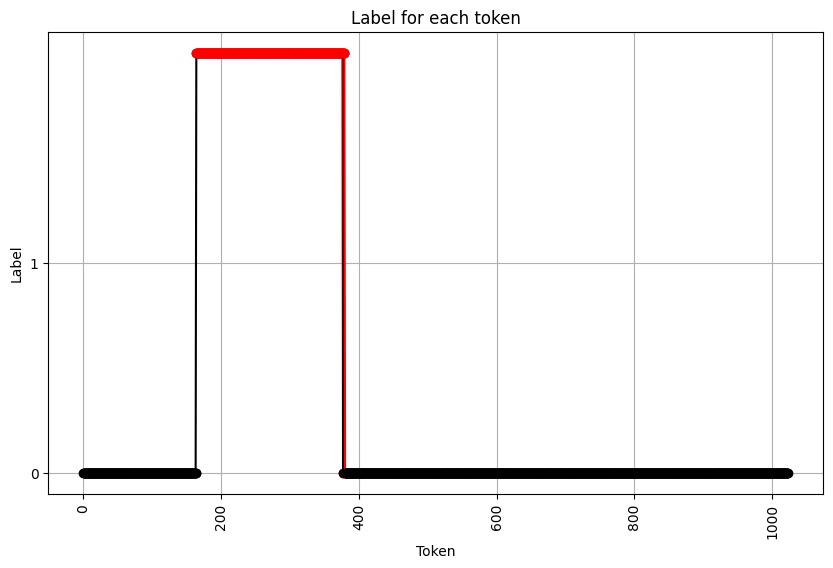

  3%|█████▌                                                                                                                                                                  | 1/30 [00:01<00:49,  1.69s/it]

MIKAPSITSLRVDKLAANFVYLKWDDVGMDFYYVVELARSRDMDGTIIPDEELIWTQLGYSYENEWFSDQVAPNTRYKFRIQTTHEGFEPSDWVISDELWTFDENAYAYTTMREFTPADSFINEKFAKNNRDYVDFNDDVIMASLMVENFVYSPLYSDVSQISDKILKQESYHEIQDHIEHVCNDIDRTFLVYSNGLLYLFERFQNMAKVSNDKGQTWYYYKALNDRVGNPVSRTVAYQSANTTYVLGYDRIFYGRTSTDIRWSSDEVRFSSDDVTFAKLGNQSGLDFDVDSYNTYARLPGGVSKYAEAIACSNEWLYVAAKNVMRRIALRNTPIDTDPGSPTFGERIFDEVSYTIVPGNDKIVVKKMDVLNDRLYVLVTGEVKTAMMDPTVKANVIPSNDAGVYLWDENAKTFTRVYGKTEDERFYITHEYTNMSTNGDEVYISVGNYKYPGTLPDLDLVEKYPEDVHSAVKYDLVPGYTASISINFATVRANQNDPTVWNFGPQEYYNEANFSWHFRDKVSTWITNDNRPLVVYPETLYTLVTDSASPASTIRVNHEVWDKGTVTIYLNNIKFTGFTKYTNGVLLYRSGGRIIGFYELSYRARDELTIFWKPDNTLMVASLVNQERENPYTPDIEPGLIDPDLSHMITRFAPQSYLDNQQFEKFGEYYLQYISLGSNSYYNKLLNLIRNKYPREKNNVEYLWSEINRRNIYLDKTKREAVVRFFESRASDFYSTKGIEASYTFLFKLLYNEDVSVEIESSNSLEYDILVSSTNISQDIVGRTIYTPTGRANVTYIEREYENGQLRWSMTLHNAQGNFIEGQVVKSEKTNFTGMVIRGVRGKQMANNSIDYINRGRSYYVMKIRSNLPTSRYKDDVLRFVHPVGFGFMGITMLTVFINSGLSMTHNETIIDILRNYRFDSGYPKFWPDRIASMDGNGNQQFDLVTGEPLYTVHPRAGEPFDVPPEYDIEEKPLNGVLPSARRFDQSPLFDCSGVKYSQF

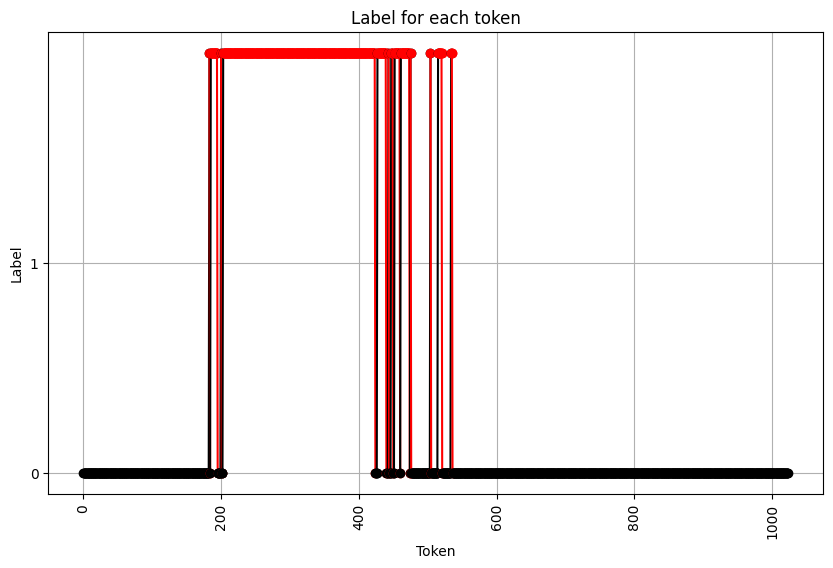

MTIAPFVTSLRIHKLSANQVNIRWDDVGANFYYFVELAETRNRAGEVIPADNLSWSSLGYTADNDWFEQNRIEPLTYYKMRVQTTSAGFEPSEWVETEEFQTFEENAYTFEHMQEFSLVKEFIKQKFSLNNMSYVNFNTSAMMASLMTESFQFSPEYSHLSAIENFVVGESGYHEIQGPIEAVCVDKNRTMLGEIDGILYLFERFQHMVKVSNDKGQNWQYVQLFNDRVGNPVSRVVIYQSKTTSYVLGYDKIFYGRKSSDVRWSSNEVKFSDNEVTFAKLGDQLKLGFEVELFGTYASLPADVTKYAEAFTCNDDYLYVVAKDTVRKVKLKDAPIDTDPLSPTFGEKVFEKEVSHITGNPKSVCFKMDSVGGKIFALITGEVKTLGLDPTDPRNVVDSATKGVYVYQEGTNTWKRVFGNTDEEKRRIEHLWTSMSTDGKEIFFSSANFKTTEYAQDIELETKYPELISTAVKNVNPIQYHSDKHYHMMSFRADEFSRWETFVPGPMRFYAEPWFVWMAREGNRCWISTSDNAVVVYNDILYQKRVDTAAQGTTERILSEVWDKGDATFYCPPVSFNGFLQYASGIMFHEPDGKLIGYYAFDYRVRDQVTLNWKPTDVMFKAFLQNQTREEDWTPEHTPGLRDPDLRPYLTKMMPDSYLLQDSNFEHFCKYYLQFLSDGNGTHYNSLVNLVKNKYPREENAWEYLWSEVYKRNIYLSKDARDAVVRFFEARKNDFYATKGIEDSYKFLFKLLYNEDVEIDIESKNTTEYDIIVESTNISDDLVGRTIYTASGRSNVTYIEREYRDGRLLWRITIHNLSGRFIEGQEIKSERTDFEGIIVQGVRGKDMLSNNIDYINRSRSYYVMKIKSQLPTSRFRDDVLRFVHPVGFGFIGITLLTMFINSGLNMKHVETIINKLKNYKWDAGLPSVYPDRVAIIASDDTIERDPITNEPRYSSRAQAGEPFPLPANYNQENNNSVIAGQNPGQRRKPLSPTFDQSAVT

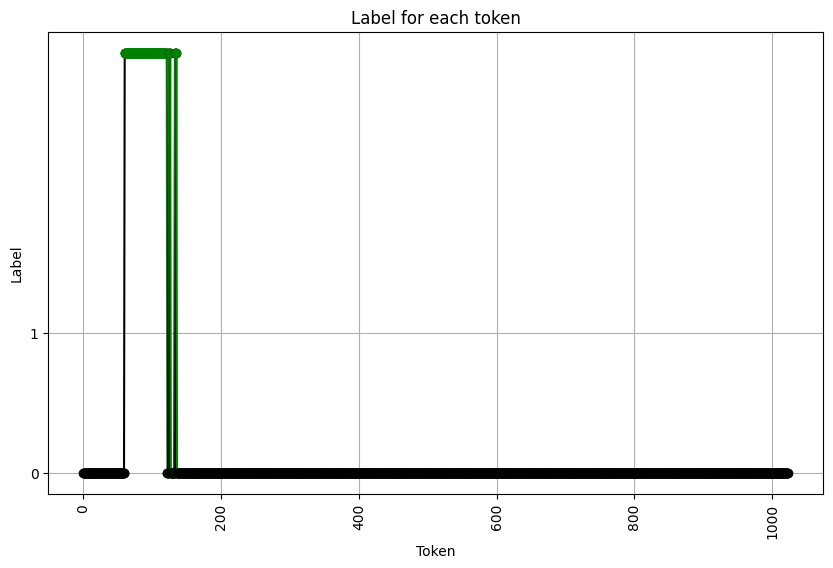

  7%|███████████▏                                                                                                                                                            | 2/30 [00:04<01:05,  2.36s/it]

MADLKAGSTVGGNPIWHAGTFPLVPAGNSLTYRGKKVYTEIDKPQADDNDFVSKSRGGTYTGEIKIAYGAAGKLSMGPLANVGIRAGGSNGEVLIIGGNSTIQLRGGGTEDSSGIVEIAKNGNLTAQTGRITANVFTSKQQPSGVDDLTRKDYVDGLINTVSNVANAAVKKAGDTMTGVLRANAGVVIVNKATSGEYAPRLDQVISRGVTIDFGTY


CAD5239183.1 hypothetical protein [Klebsiella phage vB_KaS-Ahsoka]


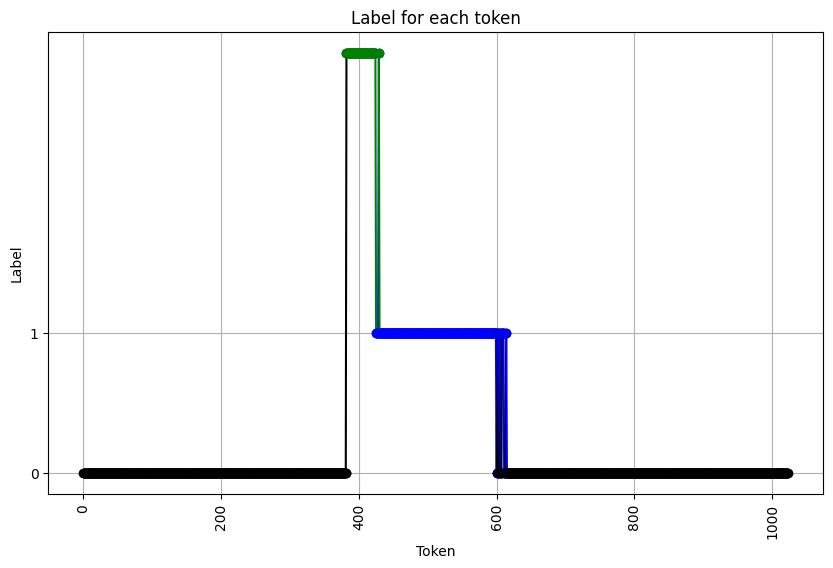

 10%|████████████████▊                                                                                                                                                       | 3/30 [00:06<00:53,  1.97s/it]

MAIYRKGQASMDADGYITGYGTNWKTALTLIRPGATIVFATNPVAYATISEIINDTSLRATSTGGAVVPQGDYVILLHDSITVDGLAQDVAETLRYYQGQETMYQDFVDFLKTFDWEKLEAIDAGVKDNAAAAAGSAANALQSEQNAFAHSQNASASAGAAAASESAAAASESAAGQSAASAKSDADRAADLADQLDATNLMRKDANLSDVVNVEQARENLDLNWLRAFGENHIASSPDLSHRLVLGNDGLFVWQTADGQTVPIAVTSGGTGSTTAEGARVNLQLDRFKQSGEQTYIYAQNKKMKIYVDDSGDWGAYDDASGTIKPLPVDRGGTGAMDVAGARNNFGLGDTQDVNFGQVTLKTKNGANGGILISDNLNSSGERVSQSRFYSEAQGGICKTTIHTSGNGKNNYVQINEDGSMSGLQEILVAGTARAGLLRSNGDVWAAQGKSVGVLTTDGGNKNIMLQNMPGDGSAGSWVNLLQGNWYNGCWQLGAIRGSGSDISQVRLCVNNSGNDWKLFDFNNSYGGHITAMRGFKGQCVAGGWGLSGEYMGAPFYADSVVANNGGYSPVVAGGTRSTVGYDLRYSFGAISGGTGDWPRPNIHMMGDGTYHRGFDFRVDGRITAWDTGIWGGSFEFQRVATSDRDLKKDIEYNDGKASFDNIMKFKPSTFVYKSDKCNRLRRGVIAQDLYEIDPEYVRIIPGSPIIDNSVEYDESGAAVIIDYKDDTLGLDNNVIMIDTALATRYIGGIVEKQQEEIDNLKAEVEELKAMISKLIEK


CAD5204309.1 side tail fiber [Klebsiella phage vB_KppS-Raw]


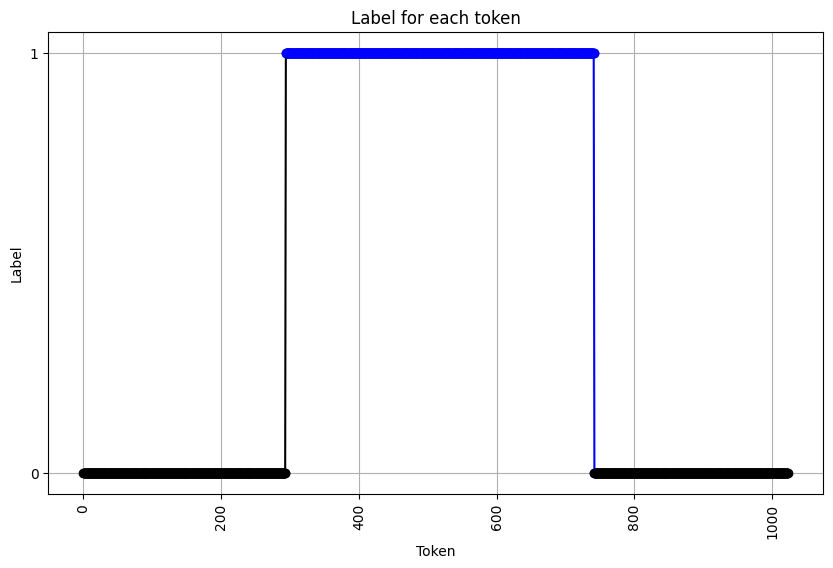

 13%|██████████████████████▍                                                                                                                                                 | 4/30 [00:07<00:44,  1.72s/it]

MTVISGVLINGFGEPMANTQLRAVATSTASAIVGTPAYAKTGTDGSYSFTLEIGFYSFSIWFDNLGWQYVGDIQILENTPNSSLDQLLVLPPSVQPMVLTRVLQALIDAEAAAALASSQAALAEAARNGAESARDAAESIVDVNGTYPTIAAGLAATTSGQYFRVPQGENSDVSFIYYQNNSGTAVVVATLSSAFINQLIGKNDNKTLATIIDKDGLSSLVVDEKGNIFAGGDSAQSVNEKADMVRQSRGPGIRRTSRADGTTFDLIDDYGQLYLPGMTVSVQQTFEKIRTRLSNLVKTKRVFDARDYGLSAFSSEDQWYALQRATLAAYAAGGGMVYIHTGAYRISRPITPMPGVGYIGPGKKLARLLPFKATAPFTYRGNETYIDNLLFSGFTIDGENQTLNPTSGYLPEIKAIFLQYWSNGIIDNMEIVNIGATGVGVDMHNNCIITRNTVVNCGRLAEEGALGASGLGIGTGFLASEPLFVSQNLCTDNTNYGIFYEPQRGVGTAQDIITTANVCLRNYAGIADCGVEGLIVADNELRENKHGFLMYPGTNNGGKPGRRGQLRGNVIRGNLVNGVTSLCEKTDPLLGEYEFKDNKIYENAVDGVNFRYTVSTVKNQNNVIQANEIYRNGRHGIAFEKGDVINVDIMDNRIYNNGQTAPGNAIDISVPMSMSSITGNKIRDTQSVVTQQRPLAISGNLTDVDISNNHGCGNAQFGQLSGTQTRVNLNNNPGIFEVVA


CAD5239143.1 tail fiber family protein [Klebsiella phage vB_KqP-Goliath]


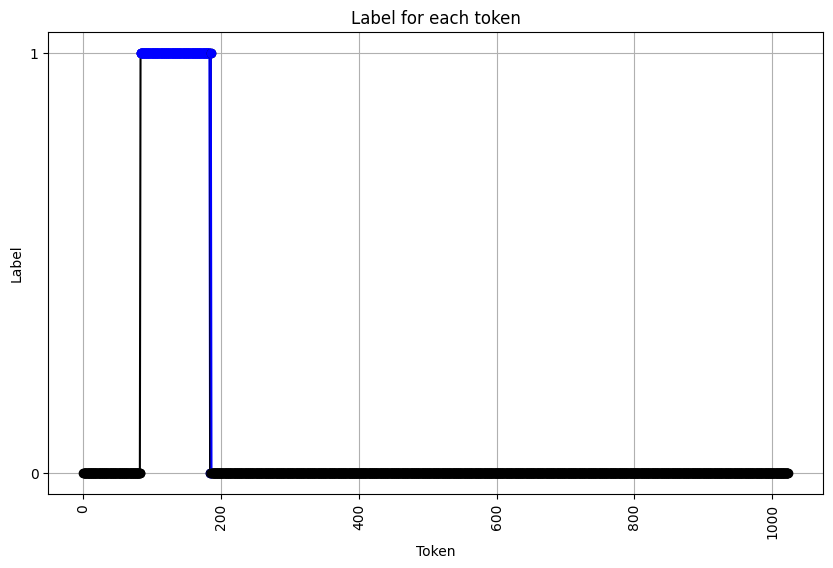

MALVDLVRAGGHSIEYPQFSSMAKLKAFPHSEDGQLVRLLSWHEGVGLGGGLFKVSTSSTATGNDGTVVVASNGVRLLRVVNGPIWADMFGALPNSDIDSMPAVAAAYAYAASVNTDLYIGVATYKFKGSTPINVDPSRAGIIGYQGKVRIDCSEFTGSVVFSINSSYSYTPAAYYNNLSPALQGLYVFGAKTSGVDGLLVGRETVGSDKSYNGQTEVRECTFDKFDRNIRMGHNSWRFVFYKVNSLNALNPNGILYVPAGLDDSGEILSFYHCQFFDGAGSNIRLSCSSYTMVFNTCSFLNITFFVDSASSATVTCNGCYFENPGSTSTRRYVDISAGHTNVFNIIGGSIVTNSNPGQTQALLYVSADNLLNLVGVTVPYGGHYQQEQELGYHAFIGGAGTVTTSGVMLQLRNGAGTCPLHPSLSTFSNWDFGYGNLNAWTVDKGTGTSSVVEYLANAGPKGTEGAMRVAPVSVGTNVSQVQAITNPGMFSMSCMVNIVTTPGNAGQISIGFLDAAGNSLPGGVAANLGTTTGWKVIGKNTLRGKVPIGAKQIRVNIQTVAGADVKYAYLLCNVVK


CAD5239132.1 tail tubular protein B [Klebsiella phage vB_KqP-Goliath]


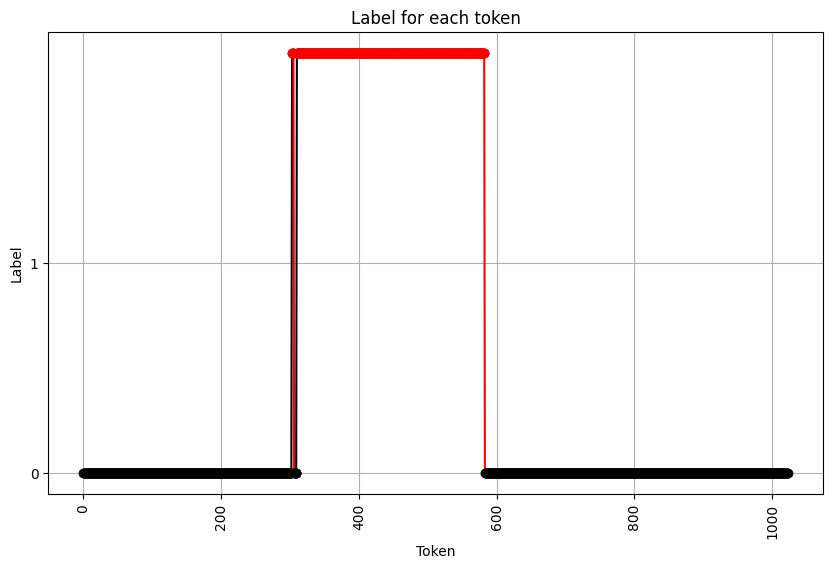

 17%|████████████████████████████                                                                                                                                            | 5/30 [00:10<00:57,  2.31s/it]

MARATTGLPLEGTIQSLLQGVSQQIPRERQPGQLGAQLNMLSDPVSGLRRRPSAEIVWESSIDNPGVDELFTEYVERGTDGRHLLINTNNGNWWLLSKNGKTIVNSGNDQYFVTTVGQTSIQTASIAGLTYILNTEMAPNTAVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSGGADYSGDYTAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAGVSNQSRVDQEQDLPAQLPSQANGAMCRVGTASSETAWYKFDYSTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNQNPGFVENGYITGIAAFQGRLVLLSGSVVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAIQFNRDLVLFANSMQAVVPGSVVLTPTNASISITSTYECDSRVTPVMAGQTVIYPNKRNNSYAGILELIPSPYTSSQYATQDATVHLPRYIPGRALQMQNSSVTNMAFVRMSGQRKNLLVYEFMWGGQDGGKVQAAWHQWTFPYNILGVQALEDEVFLYLQGPSPGNKLLILSMDPREGYNLGSEYTDAYSDLQTQVTVSGGVFTVPAVLRPVGWADTYKEDLILTYPANSPMGPTEVGLKDIAGTNQLSVVRGVPDGQYILGRRYNSTFTLTTPVLRDQNDKLVGSGHVRLLRLDVAMRNSGHFDVHVTDTPRDVDWSGELTGILMNSKELTLGQTLRMDLATITVPCRTNADTTEVTLYTKGSQELNVLDISYILRYNQRRRRI


CAD5241751.1 gp7 baseplate wedge subunit [Klebsiella phage vB_KpM-SoFaint]


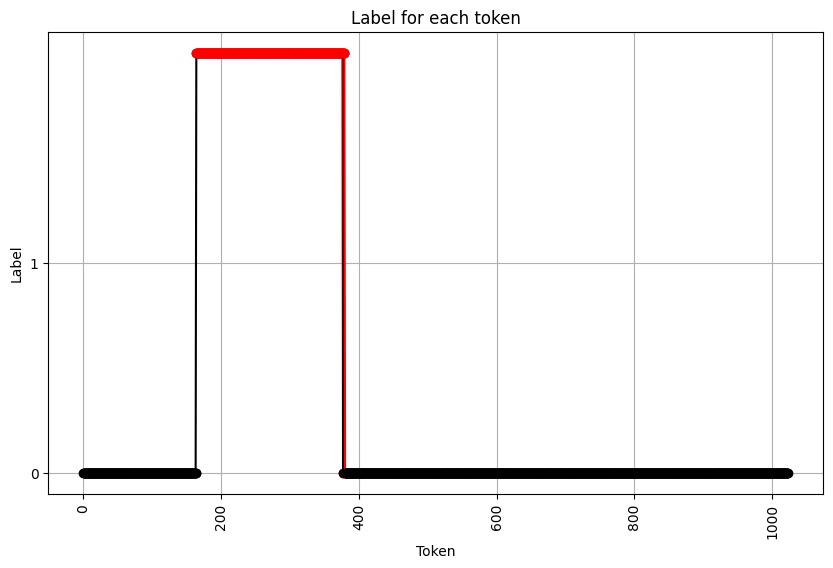

 20%|█████████████████████████████████▌                                                                                                                                      | 6/30 [00:12<00:53,  2.23s/it]

MIKAPSITSLRVDKLAANFVYLKWDDVGMDFYYVVELARSRDMDGTIIPDEELIWTQLGYSYENEWFSDQVAPNTRYKFRIQTTHEGFEPSDWVISDELWTFDENAYAYTTMREFTPADSFINEKFAKNNRDYVDFNDDVIMASLMVENFVYSPLYSDVSQISDKILKQESYHEIQDHIEHVCNDIDRTFLVYSNGLLYLFERFQNMAKVSNDKGQTWYYYKALNDRVGNPVSRTVAYQSANTTYVLGYDRIFYGRTSTDIRWSSDEVRFSSDDVTFAKLGNQSGLDFDVDSYNTYARLPGGVSKYAEAIACSNEWLYVAAKNVMRRIALRNTPIDTDPGSPTFGERIFDEVSYTIVPGNDKIVVKKMDVLNDRLYVLVTGEVKTAMMDPTVKANVIPSNDAGVYLWDENAKTFTRVYGKTEDERFYITHEYTNMSTNGDEVYISVGNYKYPGTLPDLDLVEKYPEDVHSAVKYDLVPGYTASISINFATVRANQNDPTVWNFGPQEYYNEANFSWHFRDKVSTWITNDNRPLVVYPETLYTLVTDSASPASTIRVNHEVWDKGTVTIYLNNIKFTGFTKYTNGVLLYRSGGRIIGFYELSYRARDELTIFWKPDNTLMVASLVNQERENPYTPDIEPGLIDPDLSHMITRFAPQSYLDNQQFEKFGEYYLQYISLGSNSYYNKLLNLIRNKYPREKNNVEYLWSEINRRNIYLDKTKREAVVRFFESRASDFYSTKGIEASYTFLFKLLYNEDVSVEIESSNSLEYDILVSSTNISQDIVGRTIYTPTGRANVTYIEREYENGQLRWSMTLHNAQGNFIEGQVVKSEKTNFTGMVIRGVRGKQMANNSIDYINRGRSYYVMKIRSNLPTSRYKDDVLRFVHPVGFGFMGITMLTVFINSGLSMTHNETIIDILRNYRFDSGYPKFWPDRIASMDGNGNQQFDLVTGEPLYTVHPRAGEPFDVPPEYDIEEKPLNGVLPSARRFDQSPLFDCSGVKYSQF

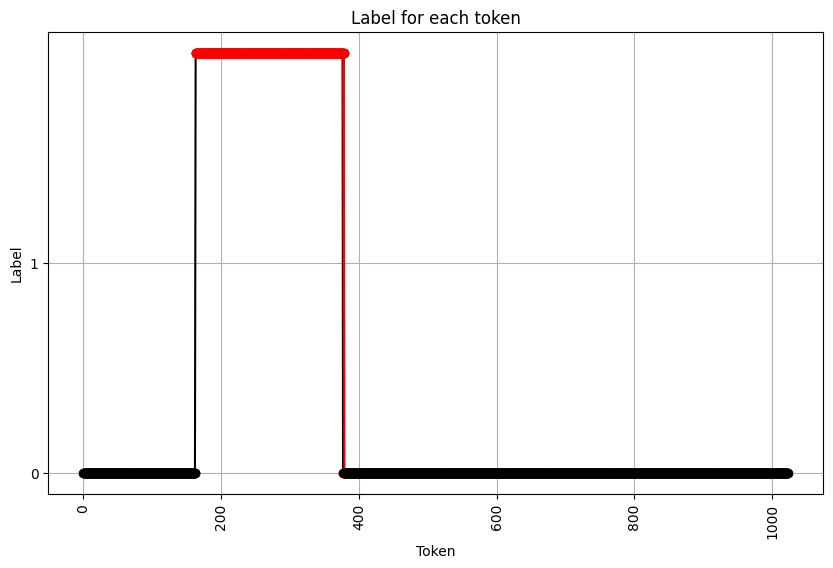

 27%|████████████████████████████████████████████▊                                                                                                                           | 8/30 [00:15<00:36,  1.68s/it]

MIKAPSITSLRVDKLAANFVYLKWDDVGMDFYYVVELARSRDMDGTIIPDEELIWTQLGYSYENEWFSDQVAPNTRYKFRIQTTHEGFEPSDWVISDELWTFDENAYAYTTMREFTPADSFINEKFAKNNRDYVDFNDDVIMASLMVEDFVYSPLYSDVSQISDKILKQESYHEIQDHIEHVCNDIDRTFLVYSNGLLYLFERFQNMAKVSNDKGQTWYYYKALNDRVGNPVSRTVAYQSANTTYVLGYDRIFYGRTSTDIRWSSDEVRFSADDVTFAKLGNQSGLDFDVDSYNTYARLPGGVSKYAEAIACSSDWLYVAAKNVMRRIALRNTPIDTDPGSPTFGERIFDEVSYTIVPGNDKIVVKKMDVLNDRLYVLVTGEVKTAMMDPTVKANVIPSNDAGVYLWDENAKTFTRVYGKTEDERFYITHEYTNMSTNGDEVYISVGNYKYPDTLPDPDLVEKYPEDVHSAVKYDLVPGYTASISINFATVRANQNDPTVWNFGPQEYYNEANFSWHFRDKVSTWITNDNRPLVVYPETLYTLVTDSASPASTIRVNHEVWDKGTVTIYLNNIKFTGFTKYTNGVLLYRSGGRIIGFYELSYRARDELTIFWKPDNTLMVASLVNQERENPYTPDIEPGLIDPDLSHMITRFAPQSYLDNQQFEKFGEYYLQYISLGSNSYYNKLLNLIRNKYPREKNNVEYLWSEINRRNIYLDKTKREAVVRFFESRASDFYSTKGIEASYTFLFKLLYNEDVSVEIESSNSLEYDILVSSTNISQDIVGRTIYTPTGRANVTYIERDYENGQLRWSMTLHNAQGNFIEGQVVKSEKTNFTGMVIRGVRGKQMANNSIDYINRGRSYYVMKIRSNLPTSRYKDDVLRFVHPVGFGFMGITMLTVFINSGLSMTHNETIIDILRNYRFDSGYPKFWPDRIASMDGNGNQQFDLVTGEPLYTAHPRAGEPFDVPPEYDIEEKPLNGVLPSARRFDQSPLFDCSGVKYSQF

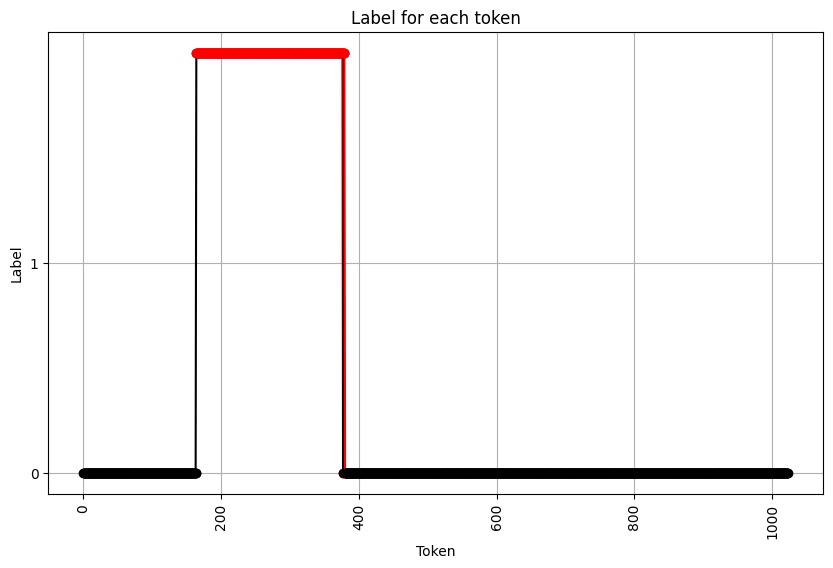

 30%|██████████████████████████████████████████████████▍                                                                                                                     | 9/30 [00:17<00:37,  1.81s/it]

MIKAPSITSLRVDKLAANFVYLKWDDVGMDFYYVVELARSRDMDGTIIPDEELIWTQLGYSYENEWFSDQVAPNTRYKFRIQTTHEGFEPSDWVISDELWTFDENAYAYTTMREFTPADSFINEKFAKNNRDYVDFNDDVIMASLMVENFVYSPLYSDVSQISDKILKQESYHEIQDHIEHVCNDIDRTFLVYSNGLLYLFERFQNMAKVSNDKGQTWYYYKALNDRVGNPVSRTVAYQSANTTYVLGYDRIFYGRTSTDIRWSSDEVRFSSDDVTFAKLGNQSGLDFDVDSYNTYARLPGGVSKYAEAIACSNEWLYVAAKNVMRRIALRNTPIDTDPGSPTFGERIFDEVSYTIVPGNDKIVVKKMDVLNDRLYVLVTGEVKTAMMDPTVKANVIPSNDAGVYLWDENAKTFTRVYGKTEDERFYITHEYTNMSTNGDEVYISVGNYKYPGTLPDLDLVEKYPEDVHSAVKYDLVPGYTASISINFATVRANQNDPTVWNFGPQEYYNEANFSWHFRDKVSTWITNDNRPLVVYPETLYTLVTDSASPASTIRVNHEVWDKGTVTIYLNNIKFTGFTKYTNGVLLYRSGGRIIGFYELSYRARDELTIFWKPDNTLMVASLVNQERENPYTPDIEPGLIDPDLSHMITRFAPQSYLDNQQFEKFGEYYLQYISLGSNSYYNKLLNLIRNKYPREKNNVEYLWSEINRRNIYLDKTKREAVVRFFESRASDFYSTKGIEASYTFLFKLLYNEDVSVEIESSNSLEYDILVSSTNISQDIVGRTIYTPTGRANVTYIEREYENGQLRWSMTLHNAQGNFIEGQVVKSEKTNFTGMVIRGVRGKQMANNSIDYINRGRSYYVMKIRSNLPTSRYKDDVLRFVHPVGFGFMGITMLTVFINSGLSMTHNETIIDILRNYRFDSGYPKFWPDRIASMDGNGNQQFDLVTGEPLYTVHPRAGEPFDVPPEYDIEEKPLNGVLPSARRFDQSPLFDCSGVKYSQF

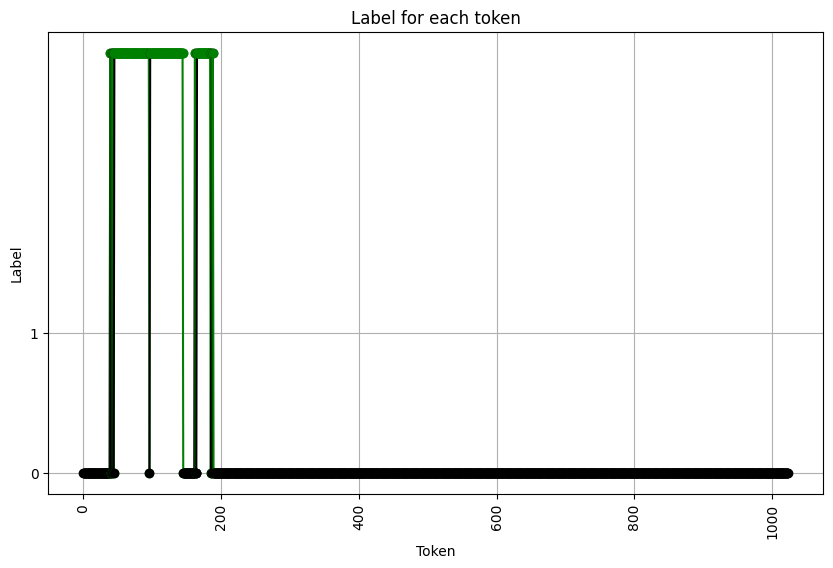

MADLKAGSTVGGLPIWHSGTFPLVPVGNTLTYRGYKVYTENDKPQASNNDFVSKASGGQYLGVVAFKQGLQINATFTGGSDQNGLYSGDGDGATFDKANIDLVSWYGIGIRSSSGTSGRVLVINARNGDVNTKGNITVEKQISITSANPTDGTHATRKSYVDGQISIVTSNANSRVLRAGDTMTGLLTAPQFASTGAASRPEHVPRLDQVITKGTIIDFGSY


CAD5242086.1 gp7 baseplate wedge subunit [Klebsiella phage vB_KoM-Liquor]


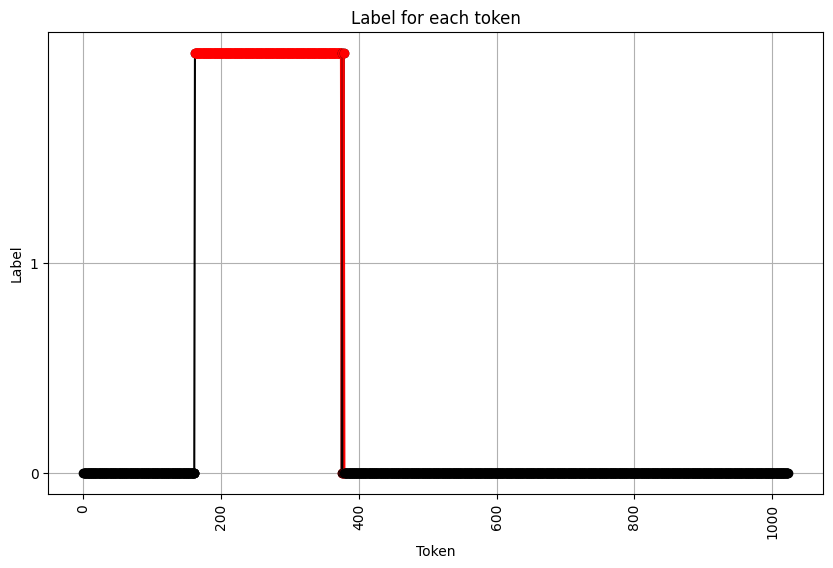

 33%|███████████████████████████████████████████████████████▋                                                                                                               | 10/30 [00:20<00:43,  2.19s/it]

MIKAPSITSLRVDKLAANFVYLKWDDVGMDFYYVVELARSRDMDGTIIPDEELIWTQLGYSYENEWFSDQVAPNTRYKFRIQTTHEGFEPSDWVISDELWTFDENAYAYTTMREFTPADSFINEKFAKNNRDYVDFNDDVIMASLMVEDFVYSPLYSDVSQISDKILKQESYHEIQDHIEHVCNDIDRTFLVYSNGLLYLFERFQNMAKVSNDKGQTWYYYKALNDRVGNPVSRTIAYQSTNTTYVLGYDRIFYGRTSTDIRWSSDEVRFSSDDVTFAKLGNQSGLDFDVDSYNTYARLPGGVSKYAEAMACSSDWLYVAAKNVMRRIALRNTPIDTDPGSPTFGERIFDEVSYTIVPGNDKIVVKKMDVLNDRLYVLVTGEVKTAMMDPTVKANVIPSNDAGVYLWDENAKTFTRVYGKTEDERFYITHEYTNMSTNGDEVYISVGNYKYPGTLPDPDLVEKYPEDVHSAVKYDLVPGYTASISINFATVRANQNDPTVWNFGPQEYYNEANFSWHFRDKVSTWITNDNRPLVVYPETLYTLVTDSASPASTIRVNHEVWDKGTVTIYLNNIKFTGFTKYTNGVLLYRSGGRIIGFYELSYRARDELTIFWKPDNTLMVASLVNQERENPYTPDIEPGLIDPDLSHMITRFAPQSYLDNQQFEKFGEYYLQYISLGSNSYYNKLLNLIRNKYPREKNNVEYLWSEINRRNIYLDKTKREAVVRFFESRASDFYSTKGIEASYTFLFKLLYNEDVSVEIESSNSLEYDILVSSTNISQDIVGRTIYTPTGRANVTYIEREYENGQLRWSMTLHNAQGNFIEGQVVKSEKTNFTGMVIRGVRGKQMANNSIDYINRGRSYYVMKIRSNLPTSRYKDDVLRFVHPVGFGFMGITMLTVFINSGLSMTHNETIIDILRNYRFDSGYPKFWPDRIASMDGNGNQQFDLVTGEPLYTAHPRAGEPFDVPPEYDIEEKPLNGVLPSARRFDQSPLFDCSGVKYSQF

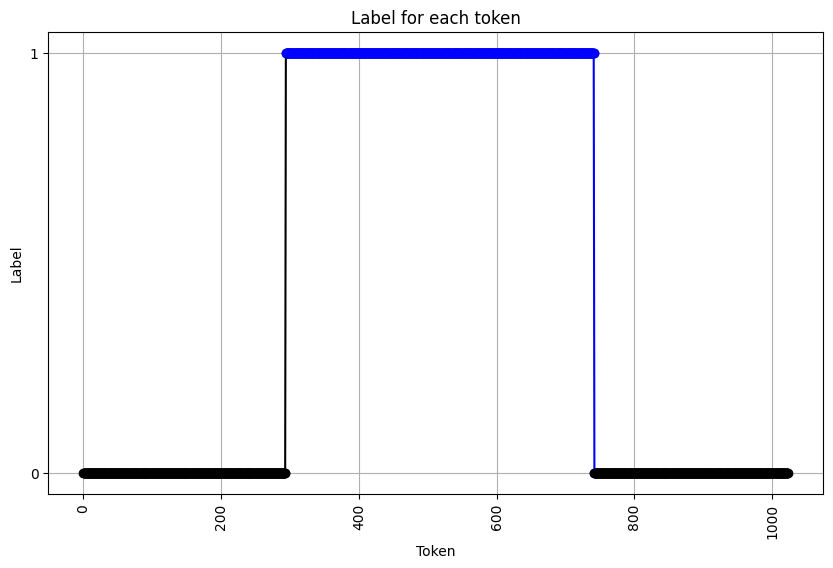

 37%|█████████████████████████████████████████████████████████████▏                                                                                                         | 11/30 [00:21<00:38,  2.01s/it]

MTVISGVLINGFGEPMANTQLRAVATSTASAIVGTPAYAKTGTDGSYSFTLEIGFYSFSIWFDNLGWQYVGDIQILENTPNSSLDQLLVLPPSVQPMVLTRVLQALIDAEAAAALASSQAALAEAARNGAESARDAAESIVDVNGTYPTIAAGLAATTSGQYFRVPQGENSDVSFIYYQNNSGTAVVVATLSSAFINQLIGKNDNKTLATIIDKDGLSSLVVDEKGNIFAGGDSAQSVNEKADMVRQSRGPGIRRTSRADGTTFDLIDDYGQLYLPGMTVSVQQTFEKIRTRLSNLVKTKRVFDARDYGLSAFSSEDQWYALQRATLAAYAAGGGMVYIHTGAYRISRPITPMPGVGYIGPGKKLARLLPFKATAPFTYRGNETYIDNLLFSGFTIDGENQTLNPTSGYLPEIKAIFLQYWSNGIIDNMEIVNIGATGVGVDMHNNCIITRNTVVNCGRLAEEGALGASGLGIGTGFLASEPLFVSQNLCTDNTNYGIFYEPQRGVGTAQDIITTANVCLRNYAGIADCGVEGLIVADNELRENKHGFLMYPGTNNGGKPGRRGQLRGNVIRGNLVNGVTSLCEKTDPLLGEYEFKDNKIYENAVDGVNFRYTVSTVKNQNNVIQANEIYRNGRHGIAFEKGDVINVDIMDNRIYNNGQTAPGNAIDISVPMSMSSITGNKIRDTQSVVTQQRPLAISGNLTDVDISNNHGCGNAQFGQLSGTQTRVNLNNNPGIFEVVA


CAD5239132.1 tail tubular protein B [Klebsiella phage vB_KqP-Goliath]


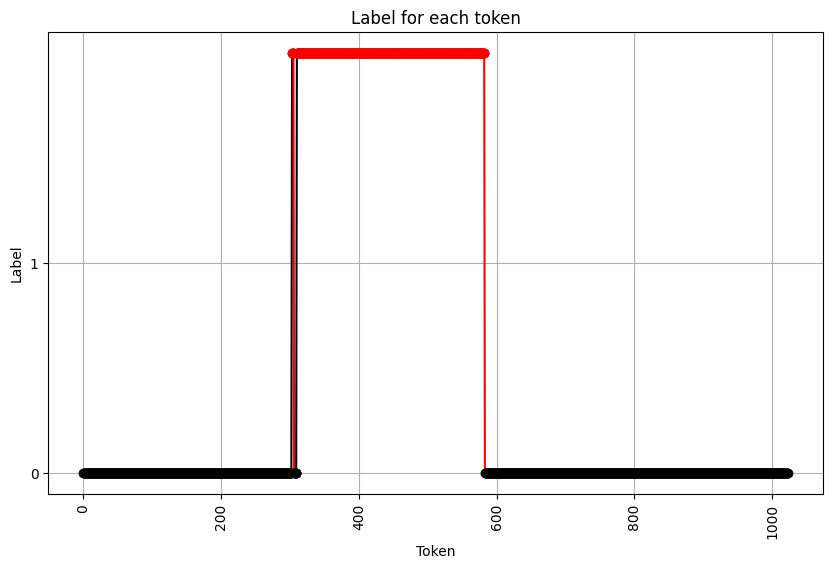

 43%|████████████████████████████████████████████████████████████████████████▎                                                                                              | 13/30 [00:23<00:26,  1.56s/it]

MARATTGLPLEGTIQSLLQGVSQQIPRERQPGQLGAQLNMLSDPVSGLRRRPSAEIVWESSIDNPGVDELFTEYVERGTDGRHLLINTNNGNWWLLSKNGKTIVNSGNDQYFVTTVGQTSIQTASIAGLTYILNTEMAPNTAVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSGGADYSGDYTAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAGVSNQSRVDQEQDLPAQLPSQANGAMCRVGTASSETAWYKFDYSTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNQNPGFVENGYITGIAAFQGRLVLLSGSVVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAIQFNRDLVLFANSMQAVVPGSVVLTPTNASISITSTYECDSRVTPVMAGQTVIYPNKRNNSYAGILELIPSPYTSSQYATQDATVHLPRYIPGRALQMQNSSVTNMAFVRMSGQRKNLLVYEFMWGGQDGGKVQAAWHQWTFPYNILGVQALEDEVFLYLQGPSPGNKLLILSMDPREGYNLGSEYTDAYSDLQTQVTVSGGVFTVPAVLRPVGWADTYKEDLILTYPANSPMGPTEVGLKDIAGTNQLSVVRGVPDGQYILGRRYNSTFTLTTPVLRDQNDKLVGSGHVRLLRLDVAMRNSGHFDVHVTDTPRDVDWSGELTGILMNSKELTLGQTLRMDLATITVPCRTNADTTEVTLYTKGSQELNVLDISYILRYNQRRRRI


CAD6025329.1 hinge connector of long tail fiber distalconnector [Klebsiella phage vB_KoM-MeTiny]


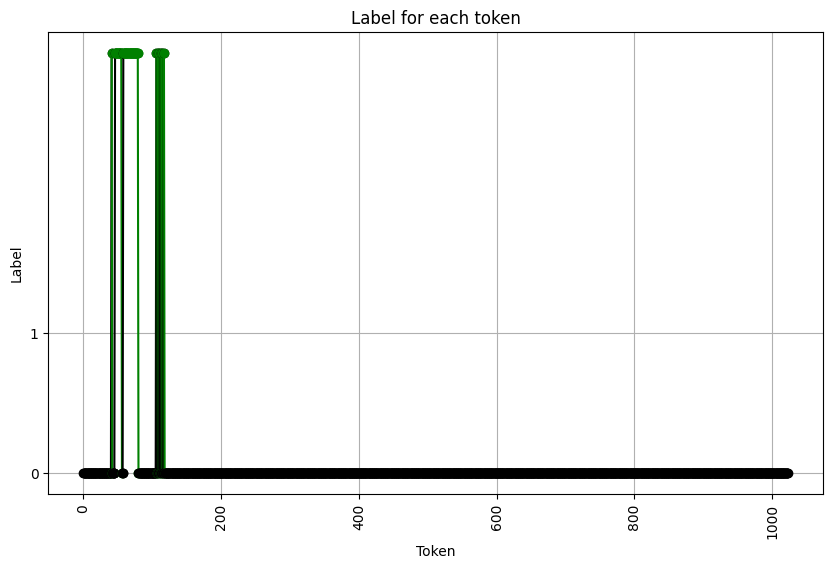

MADLKAGSTVGGLPIWHSGTFPLVPVGNTLTYRGYKVYTENDKPQASNNDFVSKASGGQYLGVVAFKQGLQINATFTGGSDQNGLYSGDGDGATLSKANIDLVSWYGIGIRSSSGTNGRVLVINARNGDLNTQGNITVEKQISITTSNPTDASHATRKSYVDGQINTVTTNANSRVLRAGDTMTGLLTAPQFASTGAASRPEHVPRLDQVITKGTIIDFGSY


CAA7537902.1 baseplate wedge subunit [Klebsiella phage vB_KpnM_05F]


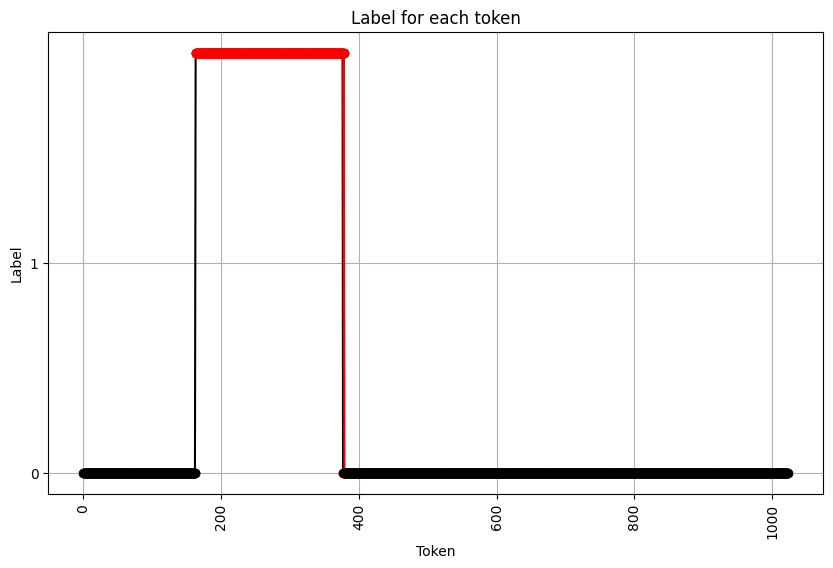

 47%|█████████████████████████████████████████████████████████████████████████████▉                                                                                         | 14/30 [00:27<00:30,  1.93s/it]

MIKAPSITSLRVDKLAANFVYLKWDDVGMDFYYVVELARSRDMDGTIIPDEELIWTQLGYSYENEWFSDQVAPNTRYKFRIQTTHEGFEPSDWVISDELWTFDENAYAYTTMREFTPADSFINEKFAKNNRDYVDFNDDVIMASLMVEDFVYSPLYSDVSQISDKILKQESYHEIQDHIEHVCNDIDRTFLVYSNGLLYLFERFQNMAKVSNDKGQTWYYYKALNDRVGNPVSRTVAYQSANTTYVLGYDRIFYGRTSTDIRWSSDEVRFSADDVTFAKLGNQSGLDFDVDSYNTYARLPGGVSKYAEAIACSSDWLYVAAKNVMRRIALRNTPIDTDPGSPTFGERIFDEVSYTIVPGNDKIVVKKMDVLNDRLYVLVTGEVKTAMMDPTVKANVIPSNDAGVYLWDENAKTFTRVYGKTEDERFYITHEYTNMSTNGDEVYISVGNYKYPGTLPDPDLVEKYPEDVHSAVKYDLVPGYTASISINFATVRANQNDPTVWNFGPQEYYNEANFSWHFRDKVSTWITNDNRPLVVYPETLYTLVTDSASPASTIRVNHEVWDKGTVTIYLNNIKFTGFTKYTNGVLLYRSGGRIIGFYELSYRARDELTIFWKPDNTLMVASLVNQERENPYTPDIEPGLIDPDLSHMITRFAPQSYLDNQQFEKFGEYYLQYISLGSNSYYNKLLNLIRNKYPREKNNVEYLWSEINRRNIYLDKTKREAVVRFFESRASDFYSTKGIEASYTFLFKLLYNEDVSVEIESSNSLEYDILVSSTNISQDIVGRTIYTPTGRANVTYIERDYENGQLRWSMTLHNAQGNFIEGQVVKSEKTNFTGMVIRGVRGKQMANNSIDYINRGRSYYVMKIRSNLPTSRYKDDVLRFVHPVGFGFMGITMLTVFINSGLSMTHNETIIDILRNYRFDSGYPKFWPDRIASMDGNGNQQFDLVTGEPLYTAHPRAGEPFDVPPEYDIEEKPLNGVLPSARRFDQSPLFDCSGVKYSQF

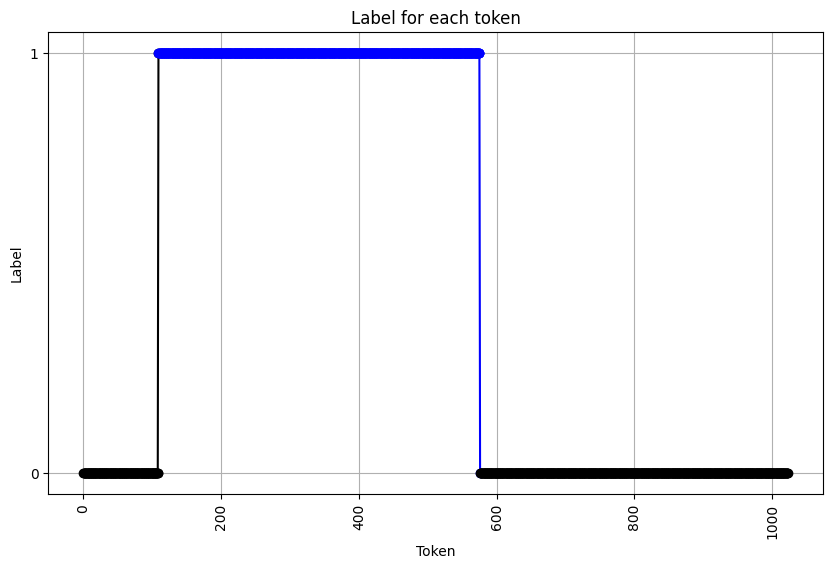

MTSRVIAKRLGDLPTYGLGYNTGALLYSEDGSNYQIPMTNFLTASKSFDVGFTITSIKEEIVYGGQRLVWTGTYPKTVPSGSTPDTTGGIGSGAWAYSNDSVLRENLRSSEEGATLVYGLGFWVDSTINIFNLSTVHAEIRSRGFYTANDGGDGVWYPTGEVNQSKAGTHIPKVAKIYDAAGHEYVLSVKSGDVVNARSNGLKAIASGSTVDDETEDFICVGEVLYGISTLVKTMKSEDDLSSYLEITVPSDYPLRVGKLSIKAFSRLKLNFQQASIYVRPSPSNKHSVTGVWMNAIERGIEDVQKISDLYSGSASYGNMTLSDFHVVGGKFYGDHKTTKSNDACNTGTGIMTYNMENSSITGTWIQDFAVGRQYLRTTSGYYYDNLGNKITGTIVPEVSSASTGSYEGVHEIDVTSYGCRYLHLRTVSNWGKFDKCKFGTYSDWSSSPDGSQFNYFVENSGAGVVFTSGVVEANTMAAGPIKGFIKDSARGAAFIGMYYENATGPGWTISTPSNSGSYRGTGLFISSLGSYYLSNSKGFPLVAFEESFFGSYDATGKYVRAGWETAYSYFAGPSTWSVGQPTVDHGAFPNGGYDFKYGTYGIHYSGSVPDVDSLRDTLEGNEFLSPYGLSVNTGVLLFPLKSPSHQSNIVVWYKDLTGNYDHRKILVGLSDNINTSDDSSINLYSTNGVSLFDYGNGYKAALVPYVNPRSLDGRLVSSAAGKLKITVTSDAPIILKAIQAFVGGVPIFPPRLSEYTPKSQLDRVWGTMSASSTDSGAYYSQEIGGGIFKPGDLVAPFVPYNHSSLTDPSSYSDMSGSFGSGFEPRTVTGGCSWGAGMAGATFSLTIDSVDSANSWTTVSVASEYLPYVFSGMPIYITANSGGGSTGLINIIRRVSNTDGTLSRQYVLKGVLGEVGGTLTASTTRSYSVKTGKSSALTGTSNSFSSDGWMGPTGGDLRTGFGGTSGTKQLRFYYDGTNVSAGIGSSGNSTLYLTGTGGIT

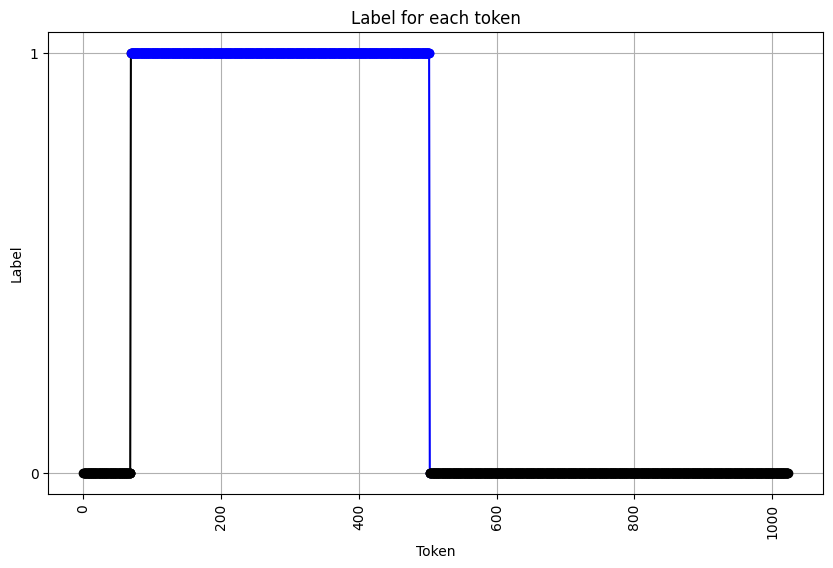

MAQTVAKKGLAALPDLGSVMGENGYLHYNEDGVDYRFPVALLSRISVLATATGAKSIGLDLTTVWNVLSGRTRNFFEFLSDDKIDSVKSGEDVDITTELQAAMDANCAIKLPDGSYYVTQAIVTSVSSSLIGDGPRNCVIDNRGIDHLFKFPSGYNRGWKVWCGFKVKSSNQAALKKYAFYFMGSATTGYLDYAASQWFQLIEFDGTGMGGGWYLQDCFRVTIRDCGASGHGNPFYIAGSVVQLTVDNYVNNGDSAPSMDVGSYGVYMANKSYTDGNGTKTPEGVNFTHCKFVRQAIGATAVGLFVNFSKCEFDYCWQYGGYYGGGSQVTFDMCYVGVQANRPNNFVGFMVPAQASGVAEKVVIHKCTVNMQTNTNTNAAIYTSKGIQVGNSTVNPIATDIVSNTFRGVGFDIGIHVVRGLGIKVDANAFLYTGVNIQVDECRTLWMTNNSTSLDGSNNPRGTYNLTTADTSAEWFVVGNDGTFVTKSIVNPARCIIMNRYWTPYVTRTSWSPSAAINVSIAAGATYGFTIAATADSTATYSLAGVNVSGLQWSIVYSNAAAVRVTFYNPTASAITLNTSLRVKTEWPPVG


YP_010644716.1 tail fiber protein [Klebsiella phage vB_KvM-Eowyn]


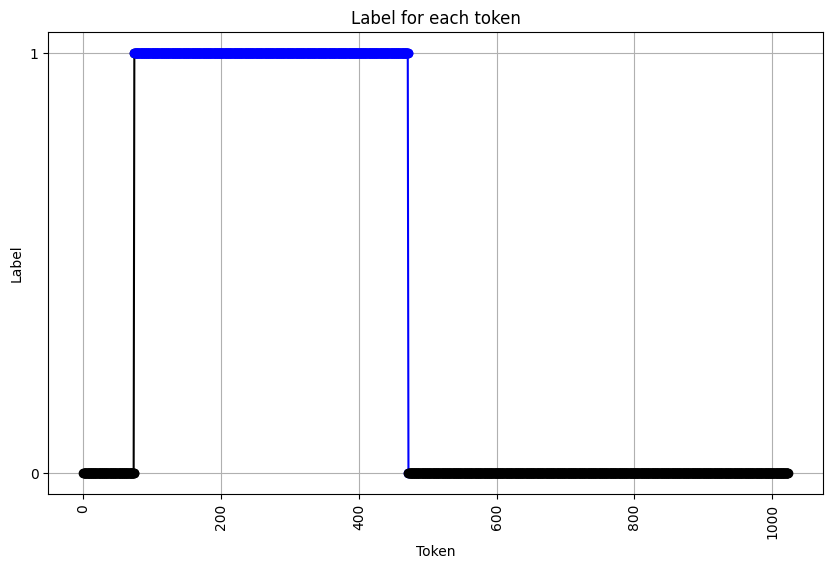

MATLPSLKKLSDLPTYSNSSPNSGTMLYTEGGVDYKLPINAVTLTSDLASTNSGKGAALVGLEQGSNVQSALRGYINAAAFGYVADYNPTTNTGTDNTIALRAAATYCLQYGIRKLVIPPGMGLISDYIPIDVGTVGEAVADRFKGCQDGFHIQGAGMYSSLLVFDAPDADTPAIKATGDWGTHTARAISDLAIVPRTTAAYNVDTLGQGIQFIGGCFIPIRNVVIGRFHKGICFWNKNKGVNDTANTFTAGDFTEFIRGNNIRIFNCDIGIDFMVTLGNNSFHGINFTQTQVQIRKYGGIGVRFYDDGSRAAIVTPSSNYQFIANVYNAKLDINLFGDDSSTCYGLYLSGAQGRGMSGDITCEGAMTLKTNSFEWYQSFGSLHSISAINLEIGATDTSTRPVAFMFSNAAYPQTYFDGSDPTLLNTSYPRQFDGNNHGNTGMDLLNIRGAQSGSIWSQVASNVSVGWIFSTRTTGGSRPAQRTVWQFSYDGTRISSAGTSVGLYNSTVGLDLTAAALVPSGNNTLNIGSASYRFNNGYFNGWNIGASGIVPTTDVSFNVGSSTFRVNRSYVASRYYTSTVFDSSGAGSPEGVVAAAIGSTYRRTDGGVSTSFYVKESGTGTSGWVSTGSVRPYVSGMFVSPGNIVLSGNYLYRYLGTAGTISTAPVPGTLWNLMTSGASCKLRATTTQTIATGVNTALTWASATTEYNSSSIYTVATAGITVPVAGIYRIAGRVAFASNNTGTRSAGLFVNGTYYAGSQARFVAKSGGYATTADYNDTLSLAAGSVITLSGFQDSGGSLDTVATAPDVSFLTISLVSYV


YP_010644722.1 tail fiber protein [Klebsiella phage vB_KvM-Eowyn]


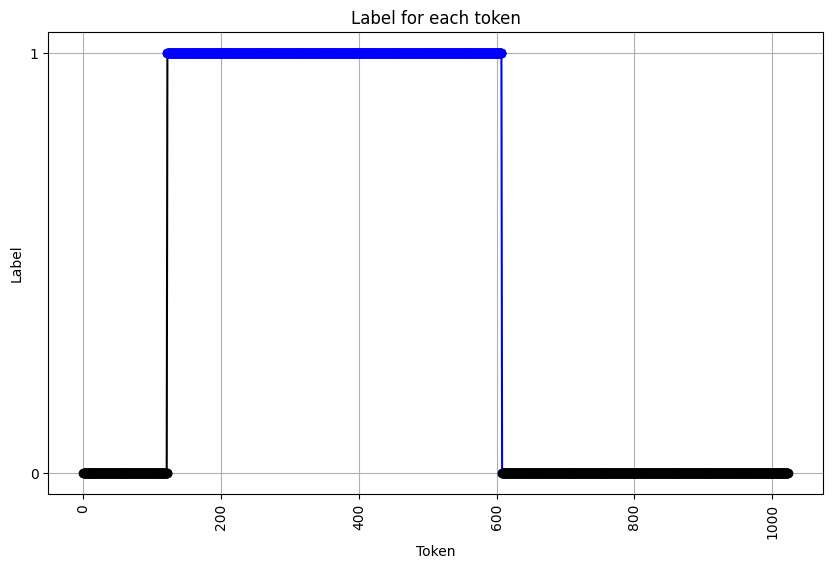

MSTKVVKKKLTDLPVYTPDDTSSGSLHYREGLTDYQLQLTSLLTKGNLAKKDGYKYIGEVSSFSELRNLVPSDNGVRVKLRGYSNNSTAGGGDFIGYLGTLLSDDGGYVASGSGYYWVRDEHEKLTPQYYGATPENTDNTAYFQAMLSGASSLGLPIYISATFSVSTLSYTGNDLIIFGPGKIIFSSTSGLVFDGCSRCKISELALQFAGVGSTGITVNNCTAISVEKCTISNHGRNGGVYVLGSTNISVRKNMFINAAGDATFGASTTADVNIWGSNSFCEIVGNKFLSGGGYGIQIRSHSLGDVSTNHVISDNIISGYNSYGINCYRNKQSLTDTQVLTYITVTNNNISNISGSRPSNPATPTVLIFGTGIYMQGAEYSIVTGNVLTNVCTASNNDLLAPAGIGITNIGNITVTDNVIVNSGMYGIKSNDSVGLGDVYGRTIISDNTIDTVGTDGIMVQDRNNIKVSGNSIKNTTRDGIKINASPSASTKLTTTDKNVSDNTVRNVVGTGIYIEYSQKYSVYGNKITTCSQGIVFQYSAYGSVNNNVVDTATTRGYYAHVTNTVDGSIVFTENRALNSTVDISVEHPIDYFNNPGMTPAGTYAEGREITSDLPNVTGCGFLNLKPTSAINFTGFLGGKIGQRITIWVNNGNATFVTSGSFILAGLKNRNPGTNGTLTFIKTKSGWVETGQSAYAITYSTPTTGSTVTIADFTGGVYIQGSTKLDTLSVVLPANPVDDQQCIICGQSGVTTLTLSASSGKTIYPTSLPTTLNTGTAIIYRYRASATAWFRYQ


YP_010644718.1 tail fiber family protein [Klebsiella phage vB_KvM-Eowyn]


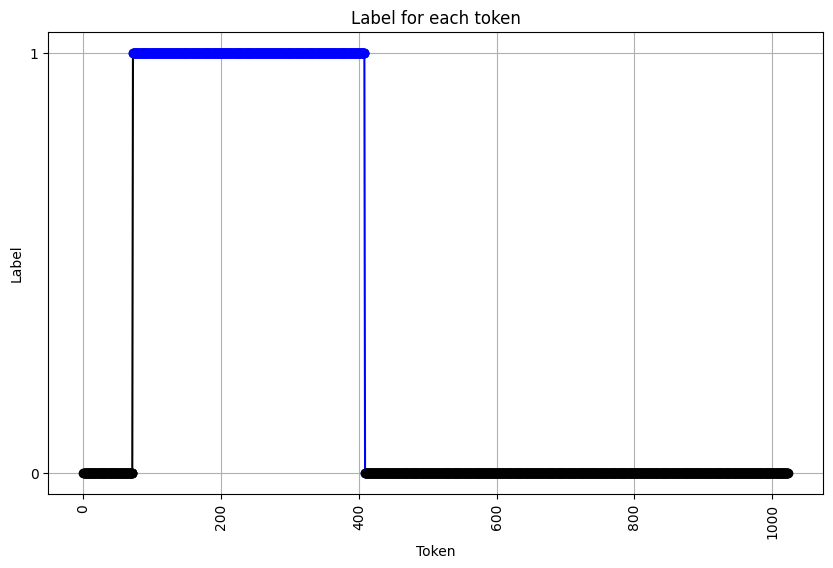

MANRAITKKISALPTYALNNNNGNLLYSEGGANYQFPLSNIALLSNLGSSETGLGASLSMTEQGITVQDALRYLTISATGLAATDEAIKNAAIAKCELLGMDLVINPGSYKFITPLVWNAKRYSIRGTGNTIIDFTGLPAGSYAITVKPEATSAGTIWNAAAHSLSGLIFKGASGIHGIKISQEINFDSPQITVRDCLFNEFDDHVTFGDNEWCCSFERVKFRANTNGSSRFVVIDKAYNGCENQRFLGCNFNGSNSGMGIKHIAGSCELTFDGCSFDYCHQVLSSVGAGARGVWRFNDTHFEDDGTMRQFDISSGNATFYVDLNQCDWAYITKDESGNNRIPTSIGAFESTNQKSTLRLSGCKFPIYDEVSDRSKSYLWVINNSAVRILANGNVIEHLTNQYFNMFSFGLNKFLALTDANRNSPALVTNGLGSITYDTSDLPANRINDNTWCITGIISGNVMIPIDPSNREINLSGNLKRTSSEYYIDVRFFTALNVQLSAISLGVPGNINTWVHFGQTIRAPTGAAFIRVGWAYAAAPSTTDTLRLNSICVEQY


YP_010644720.1 hypothetical protein [Klebsiella phage vB_KvM-Eowyn]


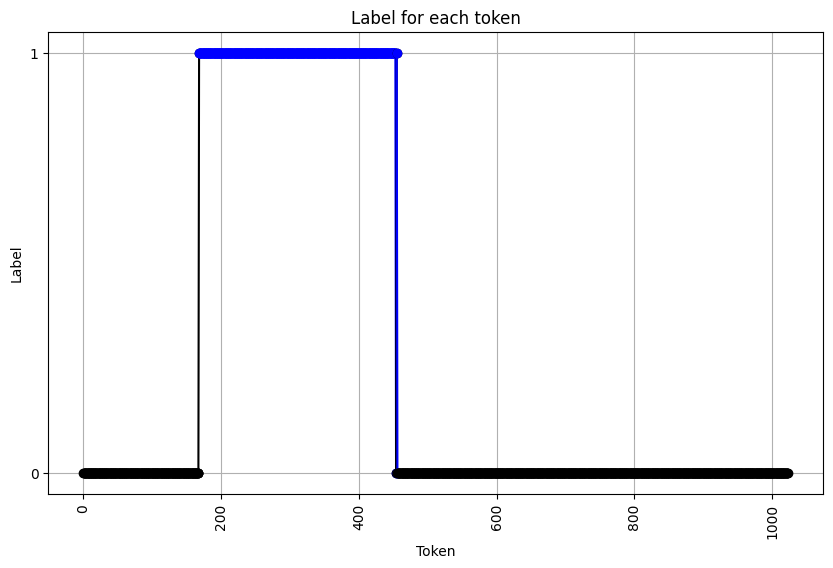

MVARAVTKKITDLPKYDLANNTGNFLYNESGTAYQYPINELVLKSELASTDVGDGASLISLEQEVSVQSAMNYLLNTGNVVRLSLYSQLSSTDDVAFSLALAASKDAAGYSKRIVVNDLGRPLILTERYVFQSVAQTSVLGDKYNENLCGVVGEYELISGGGFDFISCYSPYINIVITDGGENTIDIGTYSNSDFAVRMESGVINPEFHIVGYEYSGYLFGTCGVWGGVRAAGVQSVHKSSVAAFGGGAAIYISGTTGFGNITSVWEEGVTGNSIVDTAYDVQIASYENYIPTAGSGQLTLRSCGSCHIGKLLTGAWGIPQVKIFDCPSVDIGTHLAVLGNSDSNSINTYAADISGSVVHIGSSQLLKLGCGYRVGHGSSVTIDHINGNLINQAVIQTNNTTYDGGSTTLASTVIIKSGRIYRGNSSMVLSSLDMFYVDSTITSGKLDIASLEVLALNYGRTSDYKRLVNVLSQNTNFKVCLDGLTIDYVGSTYPIYIYNYSSLVKSIGLVFTGELQFFAGNTVGNGRVLELSSGLNTGGGTTTYSGNKRLRIYVNGTIAAGGSFSIVRSGKTVMQKTSTAAEPFSVNFDVRPGDTLTVNNTNTTISSSWSEAQFI


YP_010644713.1 tail fiber protein [Klebsiella phage vB_KvM-Eowyn]


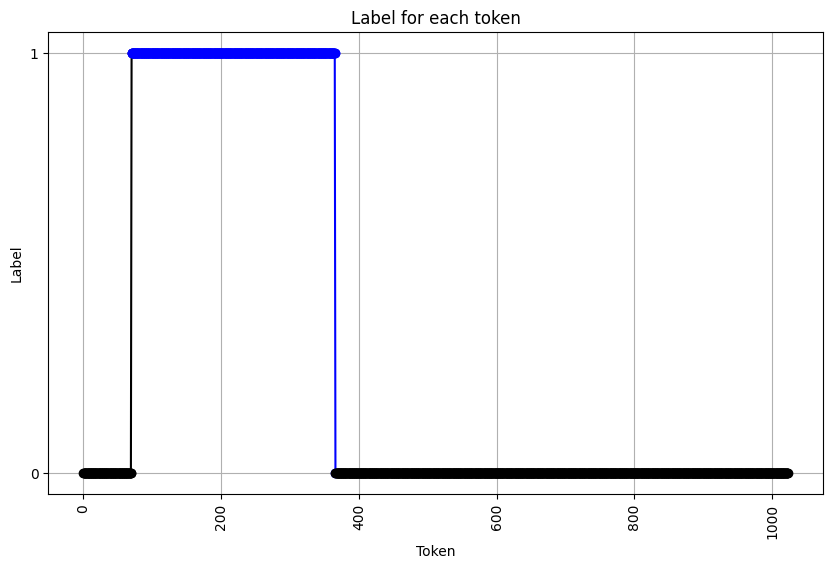

 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                              | 16/30 [00:41<00:57,  4.13s/it]

MAQTPVTKTLTDLPVYADTGYAGHLLYTDSNVEYRLPLNQIALLKDLRSTSTTMGVDLVSGSKKVFRVTDYGAVADYVRSSGTVGTNSTSAFQAAIAAAQAVNGVVYVPSAPQGYAYYINQTLYPIISSGSGLWRGASILGDGLYASSIYCDCGVNPGIHVLGTSGWPSNINISGISLYSHIKYTGIGIKEQGVCIYSVHDVGIYEFDTNLYISNGSAAGIFSEFINHERLWLKDGNTNIKFSRDGGDSSFHGINFNHCVLNNISGQTGINISSGCVVYNSDWKQLTLFGNSSVNWIVNNGSRNGFETLFFEGDGIITNNGSWYTGGTWRIQNSTGVWTDTSTVPFTTETYITPQTPTDSNFSSVGFTSISAPNVPSTSQTYRGMVRLRGNNSEGMGIIGYDSGTFERQGLALLSASAGDTFKDLVMRSLWHLNGITSFRPSFGLSYGSSGTAQLSINSTGRASGVMGRTTTGTITANASSQTITTTSFYFPESASPSLVSLKCMGPSNQLVWAGLYVGASSPIGGTTMVSLGVPVNVVGSGVTYTPPTALTVDSSGNISFTLTTSVDITYRINIIGLGVY


CAD5240565.1 hypothetical protein [Klebsiella phage vB_KqM-LilBean]


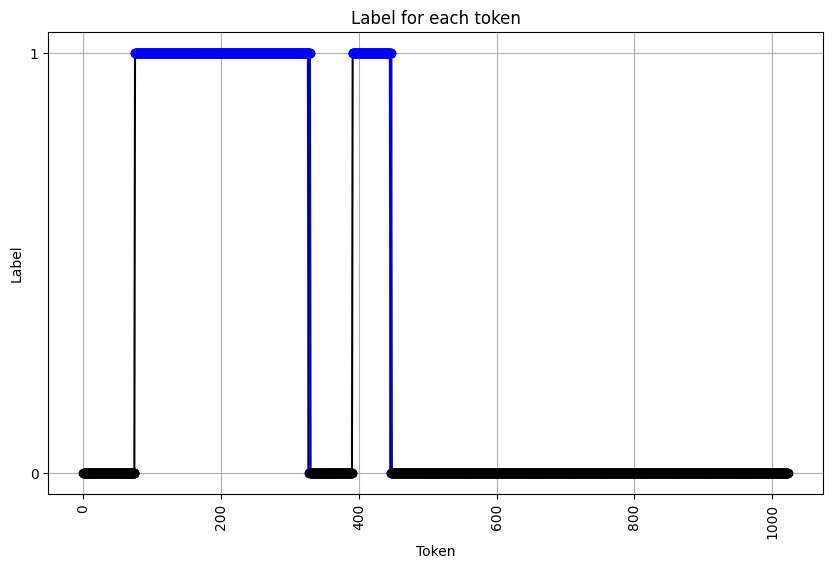

MHEFFSQKQSDVGNIAAGLVLDNLTLVFDSNTQLSYWVGANSGTIASYSVHTDGRLRVELASGSIVYLNRALVVAGATTQVWVEDFESFNTSDSDWGPAFRAAVAYASAVGINDVKFQGSYNITSTASTFGLPADDGTVSPDRIADGSEVALDPEVMYFMPVHIDLPYGVNLSANDIWLNRLTFTWNGATANLTQPIAIVGRVSNWDGTYVASPSGSNRYSSKTVKNQIYGFTISNAFIGYVADGVAQWLDWPSLRFNNVGMCFLSAGMDHCEFGYIHLSNTIAGFLSGGWWQTRNAGNYPQSKLPPYPAPDVQAAGWNDFVYFKSIMDEGKKEAWTAGSIYELVDSFFDTYFYKTRHSVTVADGGTGRMTKLTNAGADAYAAVEADPFRGVAARTFYFMSRGMHYNKCIFIDHLKVHGRHRIPICGTTYQTLTWAGKVESCYIERVPFTDTSLTTSSGNDFYTSPLNKYNTTWPYGNASRIALYTSAPASAVQGRLGVGIFCPSNALQSKATSDGANVSAAQERQTVFSNSLTAATQAPLRQVGIQTPSAYTTIDSLWRGMRFTQPLSFVATNYLTRDTSEVLFDTEAYKNSKTPITTVANGVTNGSANVALGSNSFLSYIRTRNQVEAKYFLHLPAATTDYTGTLYIPMTGLPTPLVSISSGVLGNTVPRVSIDRASYKDPASPWRTANFTLGSDGVYYLSLNKDYYASTKAALSELDADTYLVFTVNYTMVN


CAD5240417.1 putative tail fiber protein [Klebsiella phage vB_KqM-Bilbo]


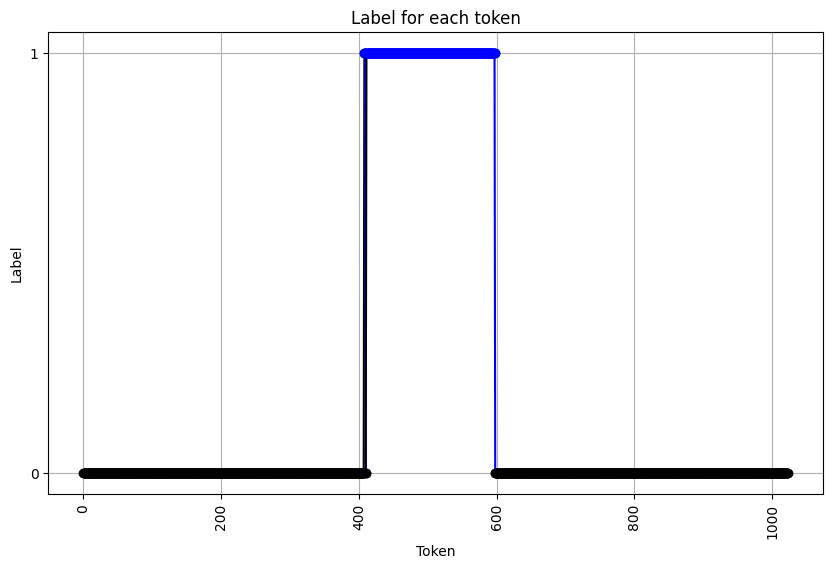

MGYFQMTRNIEEIFGGVVVAPHQIPFTYTSTNGGETFLSLPFYPVTGFVTINSGVQVPIDNFEIDGNTLNLGRELEPGDVVFCLFDKIMSPQDASNNAIRIYKFLSVGGETEFTPDFTAYGVQSLYIDGKYKTPGEDYNYFKTSGKVVLDTALPTGVWVIAEMNIKQNIPALAGNDGASNIGTSTGDTVETRLTTLDSQVDPTLRANLSSNEAALGAALVNIGQASVRDVMRANIFSYMNKADQLAIKGTVGTEVVVDYALQAAINDGVTVLECPPVPGIYVFGQSLITLPIGFSFEGKSRRTYTATSDASFNNVGTVFRLFNGASAIFKLTSRHTFRSVVFDGRNKSVRFMQGDDQTQWCRFYDCGIHRWSVGIGNSSPNGYSATLIVFGGTISSNGIGVKNVIDSLFLGATINANDTDGVQLLTGANNNAFIGVRNEWNNGDNYYGYGCKRILIQGELIDRAGKRAVAAVGGAQFTLSGVAVQRSGRLATEGTAEDAHYYIEGDTSSIIETAVHTTTGANDDGSGRQSPSYILATGGSSSDGKSFIASASNLSGYTGTSWLRSGYVKGLSVIGCTGVEDVKNFGLRRISDGVQYLGDAVSALSLSGAGNTATLTFQTTSQDFPRYSSDLLVRTLEIRARNNTSTGAVAYYSVNLIISREQASANIAVDTASVRTFSTLSSGTWGITSASPTGVSLAFAISADGATLTVTLTAIDSASRIINARLRA


CAD5240411.1 putative tailspike protein [Klebsiella phage vB_KqM-Bilbo]


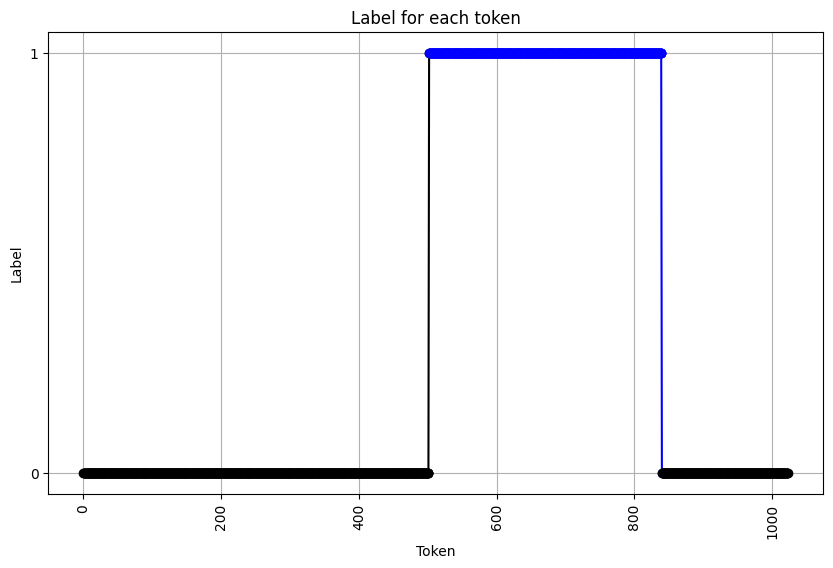

MANKPTKPNFPLGLESQDQSVFQEGILNNGVVEHGPDAVMTVPETPDASGVPSAVRYNEDDDQFEGYYNEGGWLPLGGGNGGRWELLPHAPSSLLQIGRAYLVDNIDGASTVVFPSPKRVGDSITVCDLFGKFSTYPLTVDGNGKSIYGSADSMTISTDNVSATFTWTGEARGWVITSGVGLGQGRVYSREIYSQILSATTPSITLSTQPSIVDVYVDGKRLKESLYTLDGYEVKFDPALASGSDVQIIQYIPIQLGAGGGGSGGTVITWEYNGGSAIGGETQIVLDVVVDSVSEIYIRGSRQQIGRGFTFDPATSTITLADELEAGDDVVVVINGDPTVYNQIDRSPQEVARANNVKNSEVILSTETNTVLDGKNIVYDVVAQTSWRIPTGIPAGAKINRVIGNILVYTPGNVSVNLIEIPSAYSLKSQLGSDYGSFLLNAKRKPLGEAVLAVSTAGLLYSSSWVSIMEYAHLVTNRPDPNDQTTWVWDPAIQAYLDDTGILINQTPVNSNMKAKFPLVFPPGVFKIENSYLLERIAGSTGSLATIFMFIGSGMTSTIIQPMTEGQIAFTVQDCKINFRDIGFRSGADYQTCLVLGNKTLWKPVFHCNMTRVGASGFGKGLVIYLAFDSTFEDIFVQNISKMDVTGTQVSYGITIEKYEGPANGGTAGDGTGDDSNQLVFIRPTVETAKADNSILFNVAGRSTSLPHHAINLFGGHFETHNLKAKLLNLAFGYNVNMFGTVFSQNGPTIDSDNNPITTVYRGVYIENSQNVNMFGCRIGTTNRLASVGVSDTKFIKITGTSQNVNLINTHLIGPYNDISSERHNIDNIIDYSEATKGIKSFTVQGVTAGDYTSRPITKDIRISSIDGKKEYSFYTDNSGVLHLSYSTNIADSSTPTDLMTMDTSGNILTAADLTLGALAGTAATRRLSGNGGYIAFDTIGRVYFNAVSNSQQWVMGSAAFNPTTDNAFTLGQSGFRISASFVVKRQYTATVYDSAGNGS

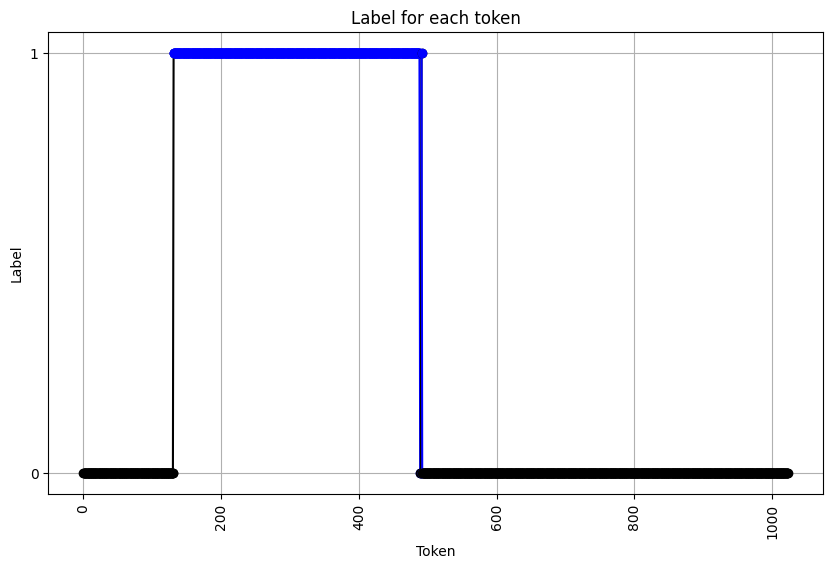

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 18/30 [00:49<00:47,  3.96s/it]

MKTQFNQSQGSTSRETNKEAIARIFGIKKSQVGYLSTSTPIDSYVILFDKETQTCWYRGSATGTPSSWTVNDDAMALTTSAGAFTLGLADIRKNMASTEYGQGAYLNGWARNDSCERASNVAVFLSAQKINLWEYKHLCVPKEGDPTTLDWAPALLKALKDGAKKRKAVYAPGMENAYYISKFGEVLTNLDTSGAESRMSVYALVGDGANQTRFVSDEMTSPVMELSLCRLMWKGWSLSGPGINSTYGIKLGDATTISAVRLSYIEDVKIGWFSNPLVIGHMWDSIFNNLHIQYWGRNAVYIQERTDDNSNNLTFNHMQLEPTQYAGSDTCRGFVCMGGSTANTKHHSIKINQPHVEPRNWNCQHFYISNCVGVDVDVPSINRNNSMVDDNGDALVANANIAPAVRIISSVGVHFNGGQITHIGTRADDVAPIIKVEGIVKDIKFDSYIDTGRASVANFAGGIDLSNSPNASREVYFDGAPVGSFTSYASVRNMLRLSVLANIQRTVSALAEQYSIAGTTDTGTVLKFLMGNTADPATAPTEIMRLYSEGYLYNKAHAAPTVTIEAGASYTHVVGAGVNNRRGEYKIIGLSDNNTLFGSFFNVPNKAPKPTGIIGDGVNLSQAQPDSSVTGKLCVYQSGQYIVLENRLSTAVTLAIRFDSGIV


CAD5240036.1 hypothetical protein [Klebsiella phage vB_KppS-Samwise]


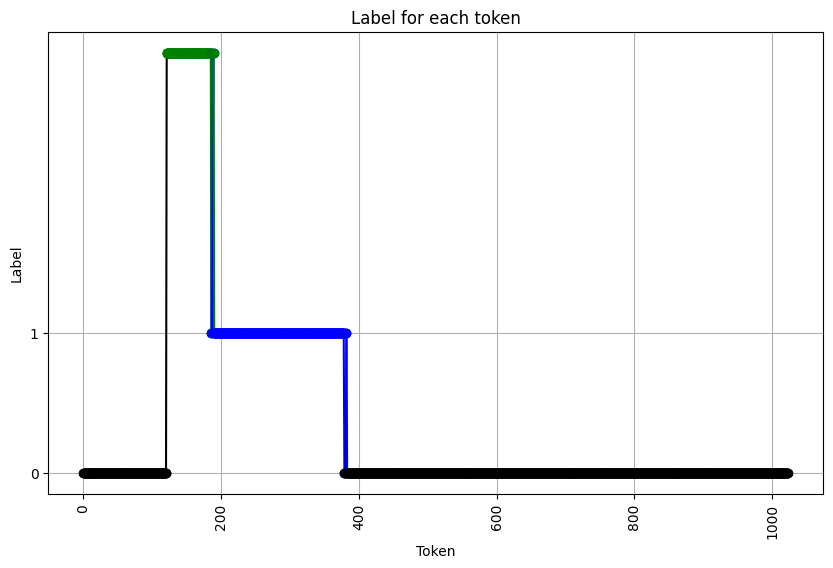

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 19/30 [00:50<00:37,  3.45s/it]

MKIYVDDSGDWGAYDDASGTIKPLPVNRGGTGSTTAEGARVNLQLDRFKQSGEQTYIYAQNKKMKIYVDDSGDWGAYDDASGTIKPLPVDRGGTGAMDVAGARNNFGLGDTQDVNFGQVTLKTKNGANGGILISDNLNSSGERVSQSRFYSEAQGGICKTTIHTSGNGKNNYVQINEDGSMSGLQEILVAGTARAGLLRSNGDVWAAQGKSVGVLTTDGGNKNIMLQNMPGDGSAGSWVNLLQGNWYNGCWQLGAIRGSGSDISQVRLCVNNSGNDWKLFDFNNSYGGHITAMRGFKGQCVAGGWGLSGEYMGAPFYADSVVANNGGYSPVVAGGTRSTVGYDLRYSFGAISGGTGDWPRPNIHMMGDGTYHRGFDFRVDGRITAWDTGIWGGSFEFQRVATSDRDLKKDIEYNDGKASFDNIMKFKPSTFVYKSDKCNRLRRGVIAQDLYEIDPEYVRIIPGSPIIDNSVEYDESGAAVIIDYKDDTLGLDNNVIMIDTALATRYIGGIVEKQQEEIDNLKAEVEELKAMISKLIEK


CAD5242887.1 phage baseplate wedge initiator [Klebsiella phage vB_KoM-Flushed]


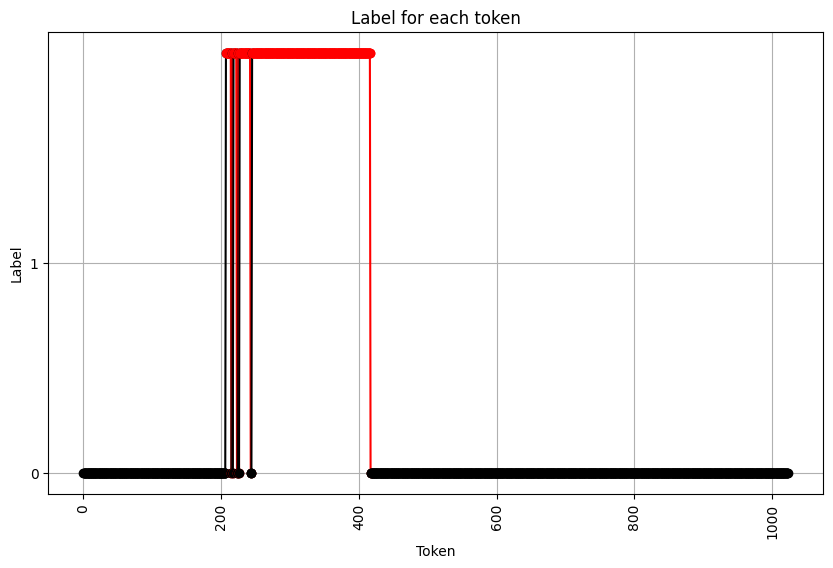

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 20/30 [00:52<00:31,  3.17s/it]

MTIAPFVTSLRIHKLSANQVNIRWDDVGANFYYFVELAETRNRAGEVIPADNLSWSSLGYTADNDWFEQNRIEPLTYYKMRVQTTSAGFEPSEWVETEEFQTFEENAYTFEHMQEFSLVKEFIKQKFSLNNMSYVNFNTSAMMASLMTESFQFSPEYSHLSAIENFVVGESGYHEIQGPIEAVCVDKNRTMLGEIDGILYLFERFQHMVKVSNDKGQNWQYVQLFNDRVGNPVSRVVIYQSSTTSYVLGYDKIFYGRKSSDVRWSSNEVKFSDNEVTFAKLGDQLKLGFEVELFGTYASLPADVTKYAEAFTCNDDHLYVVAKDTVRRVKLKDAPIDTDPLSPTFGEKVFEKEVSHITGNPKSVCFKMDSVGGKIFALITGEVKTLGLDPTDPRNVVDSATKGVYVYQEDTNTWKRVFGNTDEEKRRIEHLWTSMSTDGKEIFFSSANFKTTEYAQDIELETKYPELISTAVKNVNPIQYHSDKHYHMMSFRADEFSRWETFVPGPMRFYAEPWFVWMAREGNRCWISTADHAVVIYNDILYQKRIDMAAQGTTERVLSEVWDKGDATFYCPPVSFNGFLQYASGIMFHEPDGKLIGYYAFDYRVRDQVTLNWKPTDVMFKAFLQNQTREEDWTPEHTPGLRDPDLRPYLTKMMPDSYLLQDSNFEHFCKYYLQFLSDGNGTHYNSLVNLVKNKYPREENAWEYLWSEVYKRNIYLSKDARDAVVRFFEARKNDFYATKGIEDSYKFLFKLLYNEDVEIDIESKNTTEYDIIVESTNISDDLVGRTIYTASGRSNVTYIEREYRDGRLLWRITIHNLSGRFIEGQEIKSERTDFEGIIVQGVRGKDMLSNNIDYINRSRSYYVMKIKSQLPTSRFRDDVLRFVHPVGFGFIGITLLTMFINSGLNMKHVETIINKLKNYKWDAGLPSVYPDRVAIIASDDTIERDPITNEPRYSSRTQAGEPFPLPANYNQENNNSIIAGQNPGQRRKPLSPTFDQSAVT

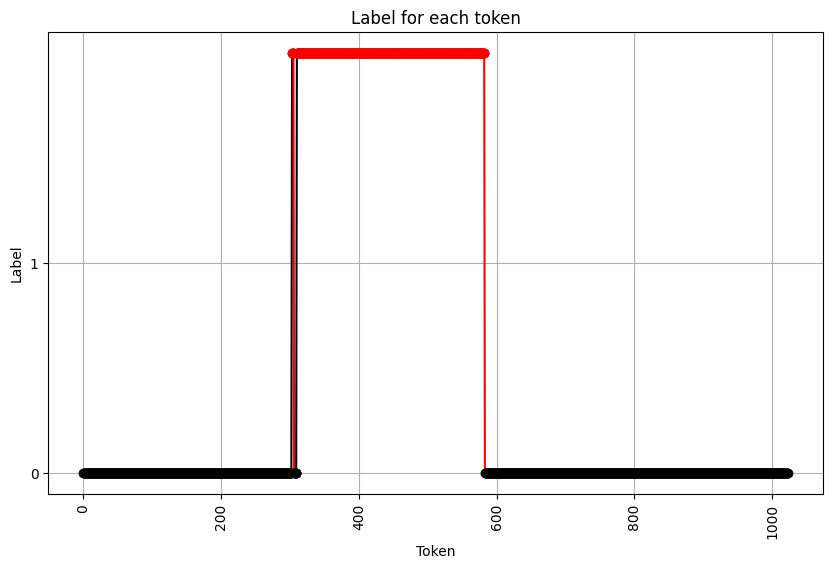

MARATTGLPLEGTIQSLLQGVSQQIPRERQPGQLGAQLNMLSDPVSGLRRRPSAEIVWESSIDNPGVDELFTEYVERGTDGRHLLINTNNGNWWLLSKNGKTIVNSGNDQYFVTTVGQTSIQTASIAGLTYILNTEMAPNTAVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSGGADYSGDYTAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAGVSNQSRVDQEQDLPAQLPSQANGAMCRVGTASSETAWYKFDYSTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNQNPGFVENGYITGIAAFQGRLVLLSGSVVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAIQFNRDLVLFANSMQAVVPGSVVLTPTNASISITSTYECDSRVTPVMAGQTVIYPNKRNNSYAGILELIPSPYTSSQYATQDATVHLPRYIPGRALQMQNSSVTNMAFVRMSGQRKNLLVYEFMWGGQDGGKVQAAWHQWTFPYNILGVQALEDEVFLYLQGPSPGNKLLILSMDPREGYNLGSEYTDAYSDLQTQVTVSGGVFTVPAVLRPVGWADTYKEDLILTYPANSPMGPTEVGLKDIAGTNQLSVVRGVPDGQYILGRRYNSTFTLTTPVLRDQNDKLVGSGHVRLLRLDVAVRNSGHFDVHVTDTPRDVDWSGELTGILMNSKELTLGQTLRMDLATITVPCRTNADTTEVTLCTKGSQELNVLDISYILRYNQRRRRI


CAD5239035.1 tail fiber family protein [Klebsiella phage vB_KpP-Screen]


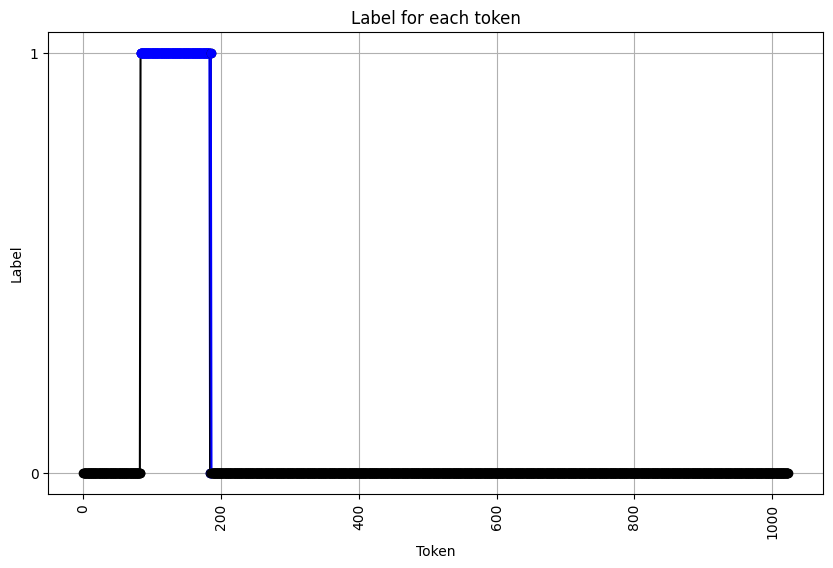

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 21/30 [00:56<00:28,  3.21s/it]

MALVDLVRAGGYSIEYPQFSSMAKLKAFPHSEDGQLVRLLSWHEGVGLGGGLFKVSTSSTATGNDGTVVVASNGVRLLRVVNGPIWADMFGALPNSDIDSMPAVAAAYAYAASVNTDLYIGVATYKFKGSTPINVDPSRAGIIGYQGKVRIDCSEFTGSVVFSINSSYSYTPAAYYNNLSPALQGLYVFGAKTSGVDGLLVGRETVGSDKSYNGQTEVRECTFDKFDRNIRMGHNSWRFVFYKVNSLNALNPNGILYVPAGLDDSGEILSFYHCQFFDGAGSNIRLSCSSYTMVFNTCSFLNITFFVDSASSATVTCNGCNFENPGSTSTRRYVDISAGHTNVFNIIGGSIVTNSNPGQTQALLYVSADNLLNLVGVTVPYGGHYQQEQELGYHAFIGGAGTVTTSGVMLQLRNGAGTCPLHPSLSTFSNWDFGYGNLNAWTVDKGTGTSSVVEYLANAGPKGTEGAMRVAPVSVGTNVSQVQAITNPGMFSMSCMVNIATTPGNAGQISIGFLDAAGNSRPGGVSANLGTTTGWKVIGKNTLRGKVPIGAKQIRVNIQTVAGADVKYAYLLCNVVK


YP_009626500.1 hinge connector of long tail fiber protein distal connector [Klebsiella phage PMBT1]


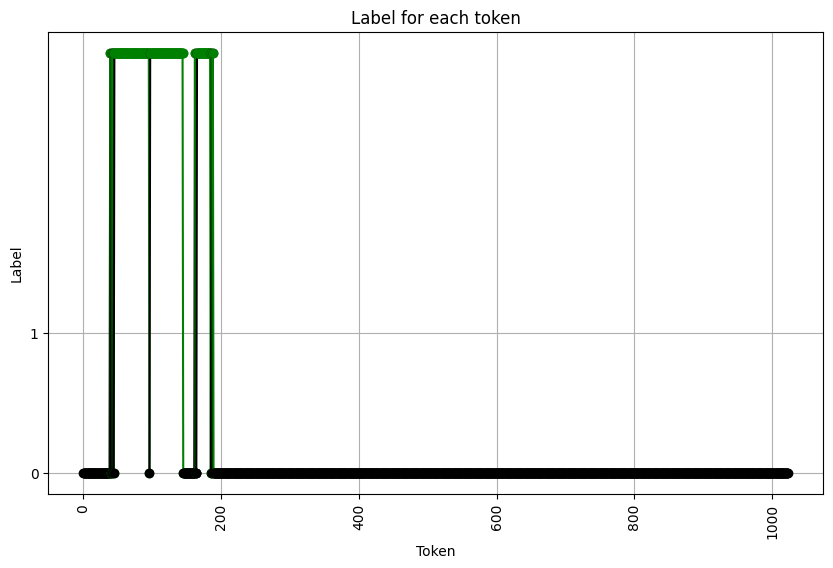

MADLKAGSTVGGLPIWHSGTFPLVPVGNTLTYRGYKVYTENDKPQASNNDFVSKASGGQYLGVVAFKQGLQINATFTGGSDQNGLYSGDGDGATFDKANIDLVSWYGIGIRSSSGTSGRVLVINARNGDVNTKGNITVEKQISITSANPTDGTHATRKSYVDGQISIVTSNANSRVLRAGDTMTGLLTAPQFASTGAASRPEHVPRLDQVITKGTIIDFGSY


CAD5242086.1 gp7 baseplate wedge subunit [Klebsiella phage vB_KoM-Liquor]


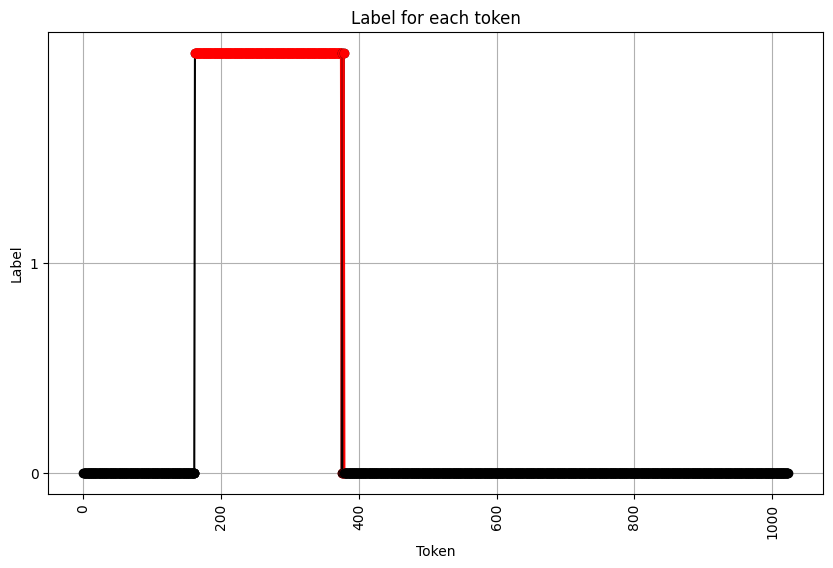

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 23/30 [00:59<00:18,  2.69s/it]

MIKAPSITSLRVDKLAANFVYLKWDDVGMDFYYVVELARSRDMDGTIIPDEELIWTQLGYSYENEWFSDQVAPNTRYKFRIQTTHEGFEPSDWVISDELWTFDENAYAYTTMREFTPADSFINEKFAKNNRDYVDFNDDVIMASLMVEDFVYSPLYSDVSQISDKILKQESYHEIQDHIEHVCNDIDRTFLVYSNGLLYLFERFQNMAKVSNDKGQTWYYYKALNDRVGNPVSRTIAYQSTNTTYVLGYDRIFYGRTSTDIRWSSDEVRFSSDDVTFAKLGNQSGLDFDVDSYNTYARLPGGVSKYAEAMACSSDWLYVAAKNVMRRIALRNTPIDTDPGSPTFGERIFDEVSYTIVPGNDKIVVKKMDVLNDRLYVLVTGEVKTAMMDPTVKANVIPSNDAGVYLWDENAKTFTRVYGKTEDERFYITHEYTNMSTNGDEVYISVGNYKYPGTLPDPDLVEKYPEDVHSAVKYDLVPGYTASISINFATVRANQNDPTVWNFGPQEYYNEANFSWHFRDKVSTWITNDNRPLVVYPETLYTLVTDSASPASTIRVNHEVWDKGTVTIYLNNIKFTGFTKYTNGVLLYRSGGRIIGFYELSYRARDELTIFWKPDNTLMVASLVNQERENPYTPDIEPGLIDPDLSHMITRFAPQSYLDNQQFEKFGEYYLQYISLGSNSYYNKLLNLIRNKYPREKNNVEYLWSEINRRNIYLDKTKREAVVRFFESRASDFYSTKGIEASYTFLFKLLYNEDVSVEIESSNSLEYDILVSSTNISQDIVGRTIYTPTGRANVTYIEREYENGQLRWSMTLHNAQGNFIEGQVVKSEKTNFTGMVIRGVRGKQMANNSIDYINRGRSYYVMKIRSNLPTSRYKDDVLRFVHPVGFGFMGITMLTVFINSGLSMTHNETIIDILRNYRFDSGYPKFWPDRIASMDGNGNQQFDLVTGEPLYTAHPRAGEPFDVPPEYDIEEKPLNGVLPSARRFDQSPLFDCSGVKYSQF

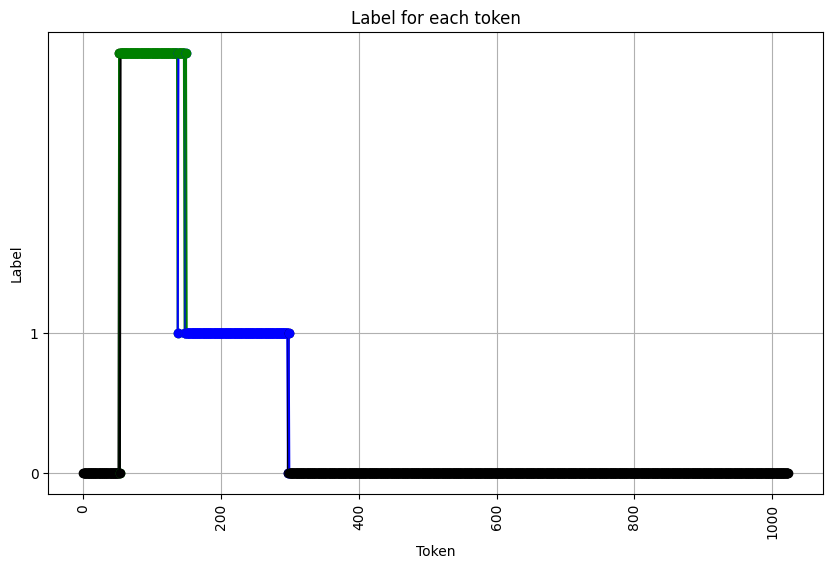

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 24/30 [01:01<00:14,  2.49s/it]

MKIYVDDSGDWGAYDDASGTIKPLPVDRGGTGAMDVAGARNNFGLGDTQDVNFGQVTLKTKNGANGGILISDNLNSSGERVSQSRFYSEAQGGICKTTIHTSGNGKNNYVQINEDGSMSGLQEILVAGTARAGLLRSNGDVWAAQGKSVGVLTTDGGNKNIMLQNMPGDGSAGSWVNLLQGNWYNGCWQLGAIRGSGSDISQVRLCVNNSGNDWKLFDFNNSYGGHITAMRGFKGQCVAGGWGLSGEYMGAPFYADSVVANNGGYSPVVAGGTRSTVGYDLRYSFGAISGGTGDWPRPNIHMMGDGTYHRGFDFRVDGRITAWDTGIWGGSFEFQRVATSDRDLKKDIEYNDGKASFDNIMKFKPSTFVYKSDKCNRLRRGVIAQDLYEIDPEYVRIIPGSPIIDNSVEYDESGAAVIIDYKDDTLGLDNNVIMIDTALATRYIGGIVEKQQEEIDNLKAEVEELKAMISKLIEK


CAD5240417.1 putative tail fiber protein [Klebsiella phage vB_KqM-Bilbo]


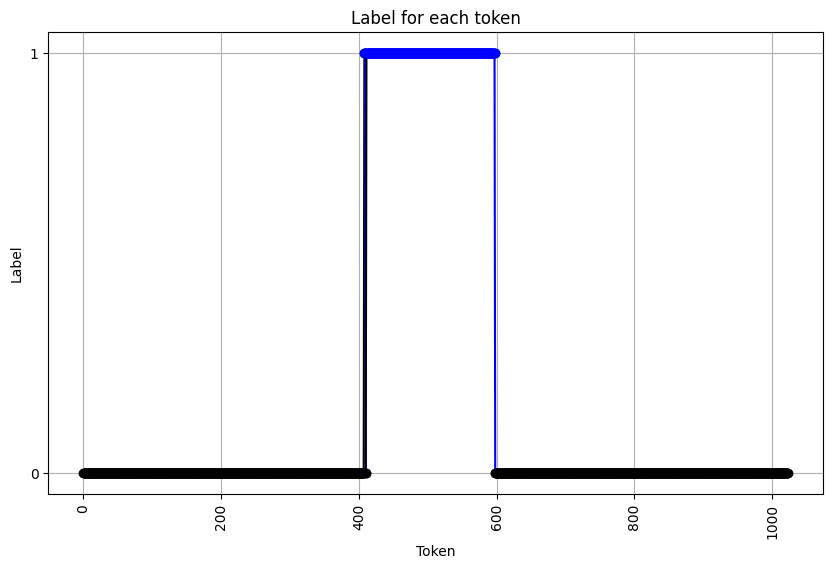

MGYFQMTRNIEEIFGGVVVAPHQIPFTYTSTNGGETFLSLPFYPVTGFVTINSGVQVPIDNFEIDGNTLNLGRELEPGDVVFCLFDKIMSPQDASNNAIRIYKFLSVGGETEFTPDFTAYGVQSLYIDGKYKTPGEDYNYFKTSGKVVLDTALPTGVWVIAEMNIKQNIPALAGNDGASNIGTSTGDTVETRLTTLDSQVDPTLRANLSSNEAALGAALVNIGQASVRDVMRANIFSYMNKADQLAIKGTVGTEVVVDYALQAAINDGVTVLECPPVPGIYVFGQSLITLPIGFSFEGKSRRTYTATSDASFNNVGTVFRLFNGASAIFKLTSRHTFRSVVFDGRNKSVRFMQGDDQTQWCRFYDCGIHRWSVGIGNSSPNGYSATLIVFGGTISSNGIGVKNVIDSLFLGATINANDTDGVQLLTGANNNAFIGVRNEWNNGDNYYGYGCKRILIQGELIDRAGKRAVAAVGGAQFTLSGVAVQRSGRLATEGTAEDAHYYIEGDTSSIIETAVHTTTGANDDGSGRQSPSYILATGGSSSDGKSFIASASNLSGYTGTSWLRSGYVKGLSVIGCTGVEDVKNFGLRRISDGVQYLGDAVSALSLSGAGNTATLTFQTTSQDFPRYSSDLLVRTLEIRARNNTSTGAVAYYSVNLIISREQASANIAVDTASVRTFSTLSSGTWGITSASPTGVSLAFAISADGATLTVTLTAIDSASRIINARLRA


CAD5240411.1 putative tailspike protein [Klebsiella phage vB_KqM-Bilbo]


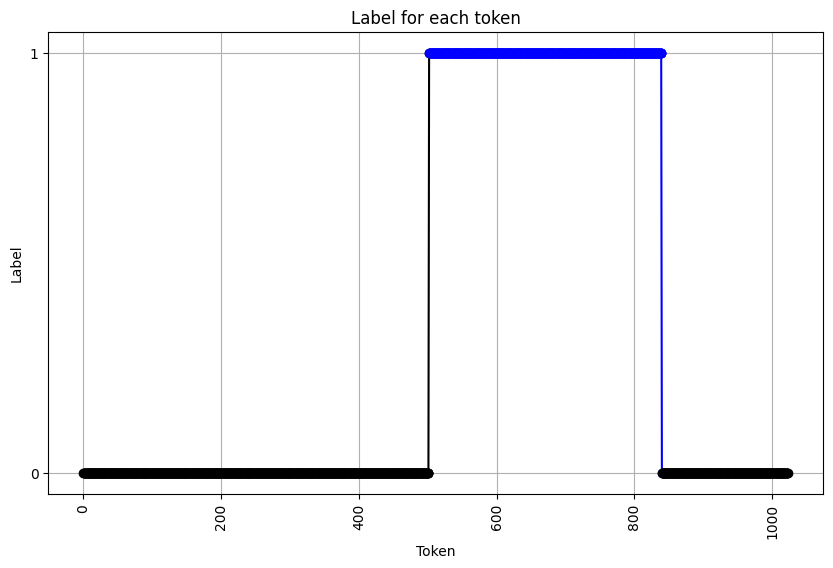

MANKPTKPNFPLGLESQDQSVFQEGILNNGVVEHGPDAVMTVPETPDASGVPSAVRYNEDDDQFEGYYNEGGWLPLGGGNGGRWELLPHAPSSLLQIGRAYLVDNIDGASTVVFPSPKRVGDSITVCDLFGKFSTYPLTVDGNGKSIYGSADSMTISTDNVSATFTWTGEARGWVITSGVGLGQGRVYSREIYSQILSATTPSITLSTQPSIVDVYVDGKRLKESLYTLDGYEVKFDPALASGSDVQIIQYIPIQLGAGGGGSGGTVITWEYNGGSAIGGETQIVLDVVVDSVSEIYIRGSRQQIGRGFTFDPATSTITLADELEAGDDVVVVINGDPTVYNQIDRSPQEVARANNVKNSEVILSTETNTVLDGKNIVYDVVAQTSWRIPTGIPAGAKINRVIGNILVYTPGNVSVNLIEIPSAYSLKSQLGSDYGSFLLNAKRKPLGEAVLAVSTAGLLYSSSWVSIMEYAHLVTNRPDPNDQTTWVWDPAIQAYLDDTGILINQTPVNSNMKAKFPLVFPPGVFKIENSYLLERIAGSTGSLATIFMFIGSGMTSTIIQPMTEGQIAFTVQDCKINFRDIGFRSGADYQTCLVLGNKTLWKPVFHCNMTRVGASGFGKGLVIYLAFDSTFEDIFVQNISKMDVTGTQVSYGITIEKYEGPANGGTAGDGTGDDSNQLVFIRPTVETAKADNSILFNVAGRSTSLPHHAINLFGGHFETHNLKAKLLNLAFGYNVNMFGTVFSQNGPTIDSDNNPITTVYRGVYIENSQNVNMFGCRIGTTNRLASVGVSDTKFIKITGTSQNVNLINTHLIGPYNDISSERHNIDNIIDYSEATKGIKSFTVQGVTAGDYTSRPITKDIRISSIDGKKEYSFYTDNSGVLHLSYSTNIADSSTPTDLMTMDTSGNILTAADLTLGALAGTAATRRLSGNGGYIAFDTIGRVYFNAVSNSQQWVMGSAAFNPTTDNAFTLGQSGFRISASFVVKRQYTATVYDSAGNGS

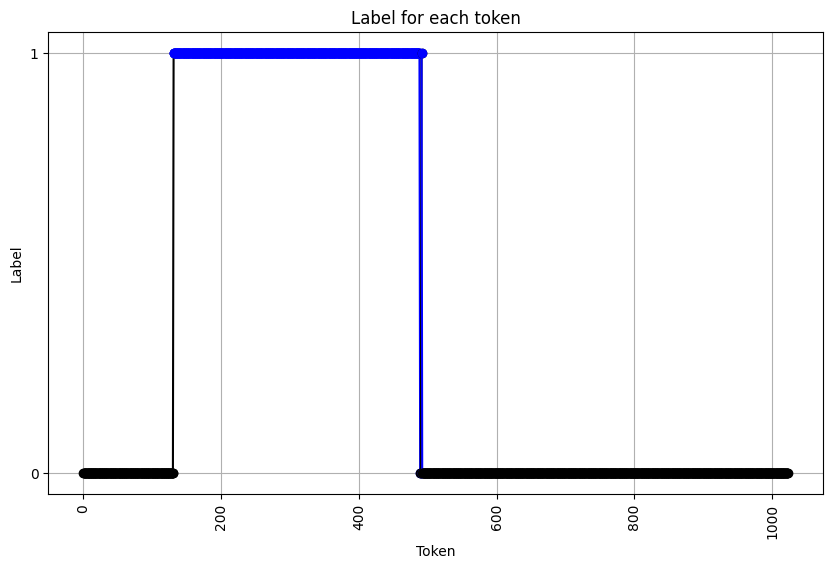

MKTQFNQSQGSTSRETNKEAIARIFGIKKSQVGYLSTSTPIDSYVILFDKETQTCWYRGSATGTPSSWTVNDDAMALTTSAGAFTLGLADIRKNMASTEYGQGAYLNGWARNDSCERASNVAVFLSAQKINLWEYKHLCVPKEGDPTTLDWAPALLKALKDGAKKRKAVYAPGMENAYYISKFGEVLTNLDTSGAESRMSVYALVGDGANQTRFVSDEMTSPVMELSLCRLMWKGWSLSGPGINSTYGIKLGDATTISAVRLSYIEDVKIGWFSNPLVIGHMWDSIFNNLHIQYWGRNAVYIQERTDDNSNNLTFNHMQLEPTQYAGSDTCRGFVCMGGSTANTKHHSIKINQPHVEPRNWNCQHFYISNCVGVDVDVPSINRNNSMVDDNGDALVANANIAPAVRIISSVGVHFNGGQITHIGTRADDVAPIIKVEGIVKDIKFDSYIDTGRASVANFAGGIDLSNSPNASREVYFDGAPVGSFTSYASVRNMLRLSVLANIQRTVSALAEQYSIAGTTDTGTVLKFLMGNTADPATAPTEIMRLYSEGYLYNKAHAAPTVTIEAGASYTHVVGAGVNNRRGEYKIIGLSDNNTLFGSFFNVPNKAPKPTGIIGDGVNLSQAQPDSSVTGKLCVYQSGQYIVLENRLSTAVTLAIRFDSGIV


CAD5240423.1 hypothetical protein [Klebsiella phage vB_KqM-Bilbo]


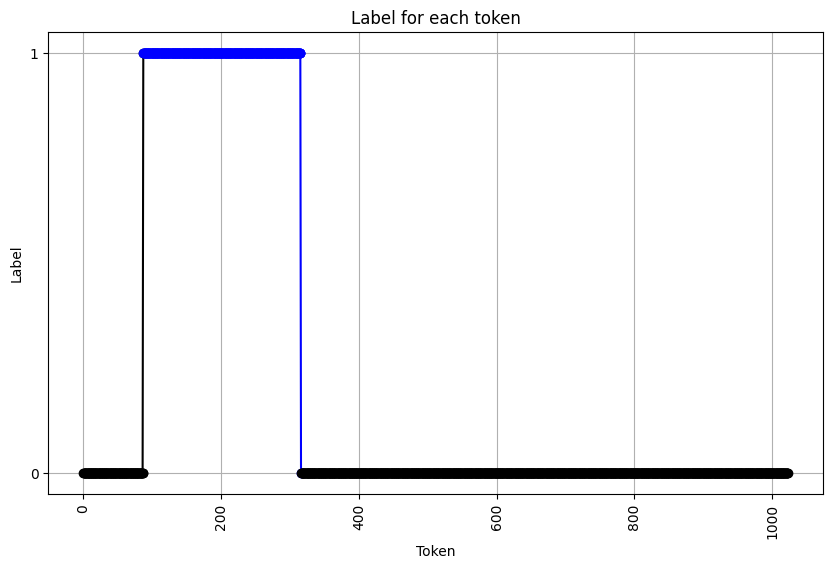

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 25/30 [01:13<00:23,  4.73s/it]

MGQWLNRLINSPLHEFFSQKQSDVGNIAAGLVLDNLTLVFDSNTQLSYWVGANSGTIASYSVHTDGRLRVELASGSIVYLNRALVVAGATTQVWVEDFESFNTSDSDWGPAFRAAVAYASAVGINDVKFQGSYNITSTASTFGLPADDGTVSPDRIADGSEVALDPEVMYFMPVHIDLPYGVNLSANDIWLNRLTFTWNGATANLTQPIAIVGRVSNWDGTYVASPSGSNRYSSKTVKNQIYGFTISNAFIGYVADGVAQWLDWPSLRFNNVGMCFLSAGMDHCEFGYIHLSNTIAGFLSGGWWQTRNAGNYPQSKLPPYPAPDVQAAGWNDFVYFKSIMDEGKKEAWTAGSIYELVDSFFDTYFYKTRHSVTVADGGTGRMTKLTNAGADAYAAVEADPFRGVAARTFYFMSRGMHYNKCIFIDHLKVHGRHRIPICGTTYQTLTWAGKVESCYIERVPFTDTSLTTSSGNDFYTSPLNKYNTTWPYGNASRIALYTSAPASAVQGRLGVGIFCPSNALQSKATSDGANVSAAQERQTVFSNSLTAATQAPLRQVGIQTPSAYTTIDSLWRGMRFTQPLSFVATNYLTRDTSEVLFDTEAYKNSKTPITTVANGVTNGSANVALGSNSFLSYIRTRNQVEAKYFLHLPAATTDYTGTLYIPMTGLPTPLVSISSGVLGNTVPRVSIDRASYKDPASPWRTANFTLGSDGVYYLSLNKDYYASTKAALSELDADTYLVFTVNYTMVN


CAD5235910.1 hypothetical protein [Klebsiella phage vB_KppS-Pokey]


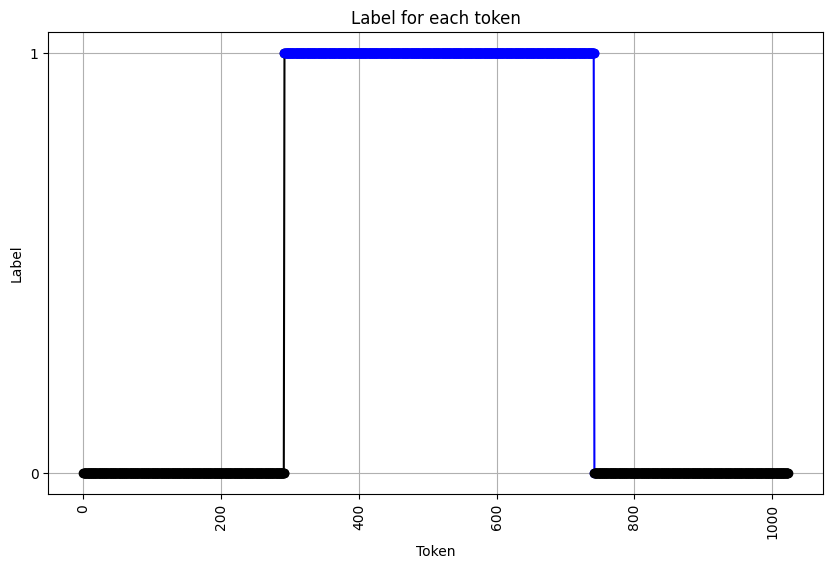

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 28/30 [01:15<00:05,  2.74s/it]

MTVISGVLINGFGEPMANTQLRAVATSTASAIVGAPAYAKTGTDGSYSFTLEIGFYSFSIWFDNLGWQYVGDIQILENTPNSSLDQLLVLPPSVQPMVLTRVLQALIDAEAAAALAGSQATLAEAARTGAESARDAAESIVDVNGTYPTIAAGLAATTSGQYFRVPQGENSDISFIYYQNNSGTAVVVATLSSAFINQLIGKNDNKTLAAIIDKDGLSSLVVDEKGNIFAGGDSTQSVNEKSDMVRQSRGPGIRRTSRADGTTFDLIDDYGQLYLPGMTVSVQRTFEKIRKRLSNLVKTKRVFDARDYGLSAFSSEDQWYALQRATLAAYAAGGGMVYIHTGAYRISRPITPMPGVGYIGPGKKLARLLPFKATAPFTYRGNETYIDNLLFSGFTIDGENQTLNPTSGYLPEIKAIFLQYWSNGIIDNMEIVNIGATGVGVDMHNNCIITRNTVVNCGRLAEEGALGASGLGIGTGFLASEPLFVSQNLCTDNTNYGIFYEPQRGVGTAQDIITTANVCLRNYAGIADCGVEGLIVADNELRENKHGFLMYPGTNNGGKPGRRGQLRGNVIRGNLVNGITSLCEKTDPLLGEYEFKDNKIYENAVDGVNFRYTVSTVKNQNNVIQANEIYRNGRHGIAFEKGDVINVDIMDNRIYNNGQTAPGNAINITVPMSMSSITGNKIRDTQSVVTQQRPLAISGNLTDVDISNNHGCGNAQFGQLSGTQTRVNLNNNPGIFEVVA


CAD5240876.1 putative tail fiber [Klebsiella phage vB_KqM-Westerburg]


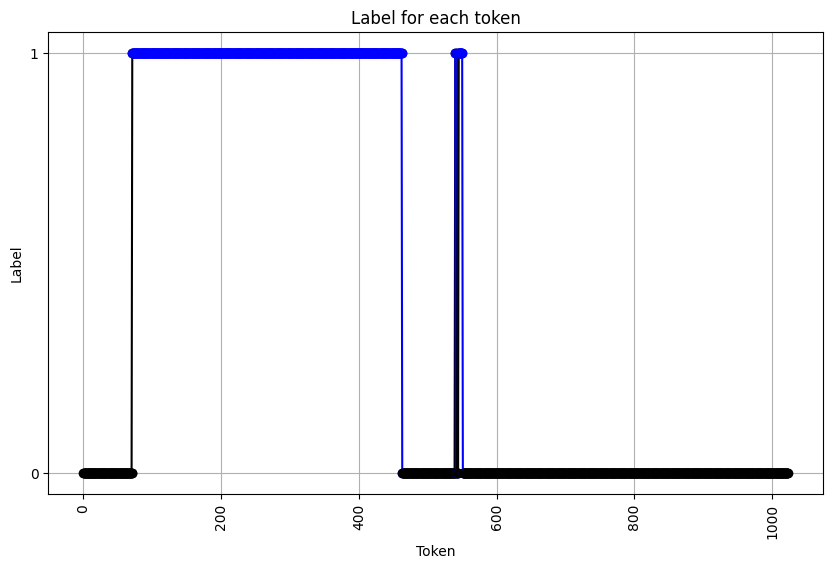

MPNVDLQNNPHNILFAFDGITRYRIHEGGTVNKPLKQVGPFYLCSLTNYMYVEQYALSDPYPTASFSDVNMTQQTASYTLNYGRGSDLTVYNSNCQGYGWGATGGGDIIANTTFINCNFNRYDSHNPVIGYFKIIDSTFGVGGVAVAGWGDVHLERPVWNMNPRVNDPYGSNTPMFIRIRETHGGWYDGDLYIKDAVINGWTDTAPNFIDAPQNSDTSLPAGSPISPYAFRNVYVDGLTFTKPTVGKKLSKFHSLTGSLSSALYAPEHIVINRLNYNCYGSANPEDDALVFDFSNVKQNPNNTTANHTAIEPASTRISISESRLQALVFKRGAIAANHNIDVTLDGVTPATPYSDFVSLYTNLKGTYTIKNSKIYRISDSVSGGAIATAIVVKMEGGMMKQGGTSDLPIVTAGAYAHDISFSDVTFVGNYSHTAVTAQNQNLAQWGSLNNCNYYNQSGGIVPHLMLWSGSIGTSETAIGASVHDGNTLITALNINSIVTYDMYRVVNVTGPVGRYIYNPSTAGYYLNLSRNGHRVTIVSGYGSASIRELHVK


CAD5240864.1 putative tailspike protein [Klebsiella phage vB_KqM-Westerburg]


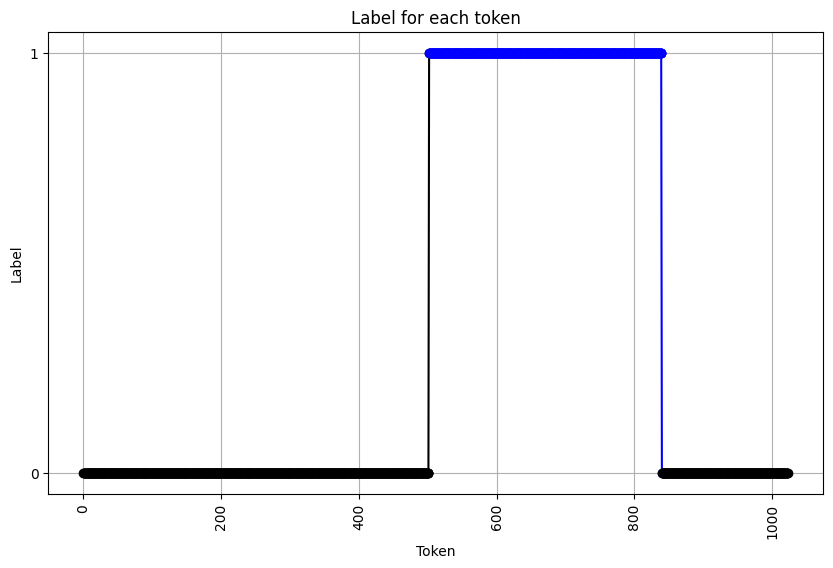

MANKPTKPNFPLGLESQDQSVFQEGILNNGVVEHGPDAVMTVPETPDASGVPSAVRYNEDDDQFEGYYNEGGWLPLGGGNGGRWELLPHASSSLLQLGRAYLVDNIDGASTVVFPSPKRVGDSITVCDLFGKFSTYPLTVDGNGKSIYGSADSMTISTDNVSATFTWTGEARGWVITSGVGLGQGRVYSREIYSQILSATTPSITLSTQPSIVDVYVDGKRLKESLYTLDGYEVKFDPVLASGSDVQIIQYIPIQLGAGGGGSGGTVITWEYNGGSAIGGETQIVLDVVVDSVSEIYIRGSRQQIGRGFTFDPATSTITLADELDAGDDVVVVINGDPTVYNQIDRSPQEVARANNVKNSEVILSTETNTVLDGKNIVYDVVAQTSWRIPTGIPAGAKINRVIGNILVYTPGNVSVNLIEIPSAYSLKSQLGSDYGSFLLNAKRKPLGEAVLAVSTAGLLYSSSWVSIMEYAHLVTNRPDPNDQTTWVWDPAIQAYLDDTGILINQTPVNSNMKAKFPLVFPPGVFKIENSYLLERIAGSTGSLATIFMFIGSGMTSTIIQPMTEGQIAFTVQDCKINFRDIGFRSGADYQTCLVLGNKTLWKPVFHCNMTRVGASGFGKGLVIYLAFDSTFEDIFVQNISKMDVTGTQVSYGITIEKYEGPANGGTAGDGTGDDSNQLVFIRPTVETAKADNSILFNVAGRSTSLPHHAINLFGGHFETHNLKAKLLNLAFGYNVNMFGTVFSQNGPTIDSDNNPITTVYRGVYIENSQNVNMFGCRIGTTNRLASVGVSDTKFIKITGTSQNVNLINTHLIGPYNDISSERHNIDNIIDYSEATKGIKSFTVQGVTAGDYTSRPITKDIRISSIDGKKEYSFYTDNSGVLHLSYSTNIADSSTPTDLMTMDTSGNILTAADLTLGGLAWTAATRRLSGNGGYIAFDTIGRVYFNAVSNSQQWVMGSTAFNPTTDNTFTLGQSGFRISASFVVKRQYTATVYDSAGNGS

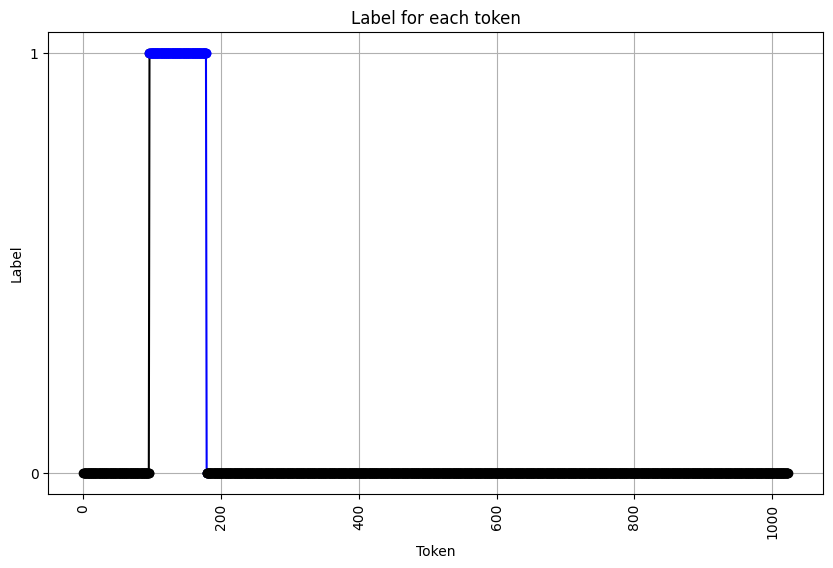

MNPQFSQAGGSVSKDVNKQSIARSLGVKVGDVVYLKQGITLQDYKAYFDKSSQLVFLKTPDVTGTLVSWSVDVASLTLTLTTSNNVYNLFIAPNSLTTKKTLTFDMFYIDKSGNTDVTSKIKSVFDIANKFKLPVTQNDGLYLISGSFTIICNYGFNLSGCTLKLASNTTGQFKISQPAGPTTYSAGSPLLNMINAASGTDLIAGNGLLTSLKNDTTLNNTFCFFTGVDDLFQYTGNASPSKWKHNCAVYHYGLLAIPFKYGGFRIRIHIFFAYSETSDGSALA


CAD5240880.1 unknown product [Klebsiella phage vB_KqM-Westerburg]


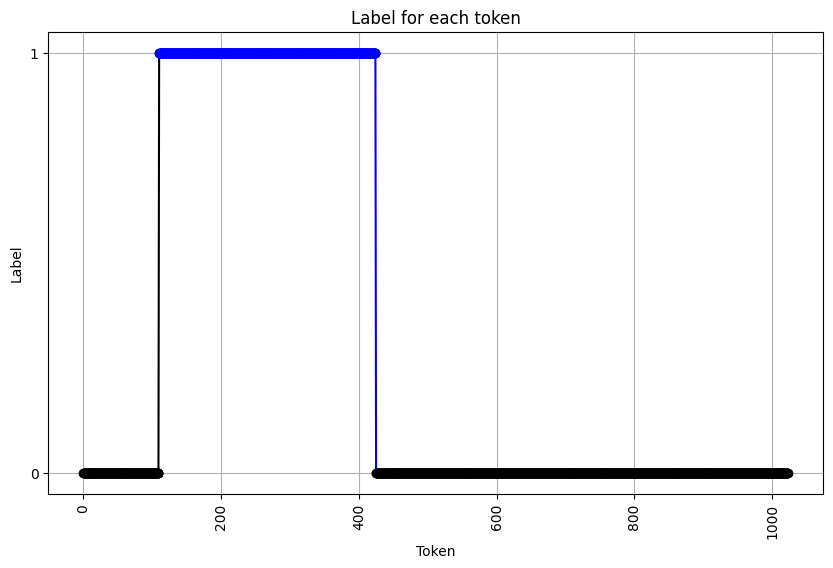

MKTQFNQPQGSTAIEVNRQTLARIWGYPIRSTIYLNTYTNVTGSSIIFEPDTGTMWYTGTAQGTPVSWVVNSKSLTLNMNQGVFTCWPAIALSRDITSETQSIRSFTERADDIPSILDWDSDSSNDDSSRIIRAIADGIRTLYVPSTRTFNIGEIDINTNMLIYGNGISGYRQVGGKFVVAADAEYGFAFTGSGNGNAGNGNRVIGGGLSGLSIIGENSACAADMVRVLHASSHEFRNVSFRLTQGSAFTLEDFMESRIEACYMNNIGADGNPVIYIKDYVDSLPWNVNNLHIRENTFGSCSGNWIHMSDRSNADLIWIHGNKFEWDSTPISPNISSKSVIYAGLVERVSIKDNGFVYFYPAHNMYDTILELGANANYGVTFSDNMAWGCTNANYWKTAGGALAGHNNRSNAPMSTVNTSSYSQDIEEPIIRTSTGNKPTSYAAKKNDVEFISVHQLTGANDSNNFVVDADAVMYGTCMNTPASSEFRRAFIPKDMLSSGRMVKVSLRCKNVNSSDGQLQLLLNGNAITDSVSGQSTGLNYITIPANSGWKEYSWYLNASQLASGGALIFRNNSSVRFLFDGVRIEYARSVSITIPWSATSIPANTVSSTTLAMGSRLVSHIKGVTSVSANGSLGGAVSSAYLRASDNTLVVQLMTAASSATVAATSLTLSLILE


CAD5240870.1 putative tail fiber protein [Klebsiella phage vB_KqM-Westerburg]


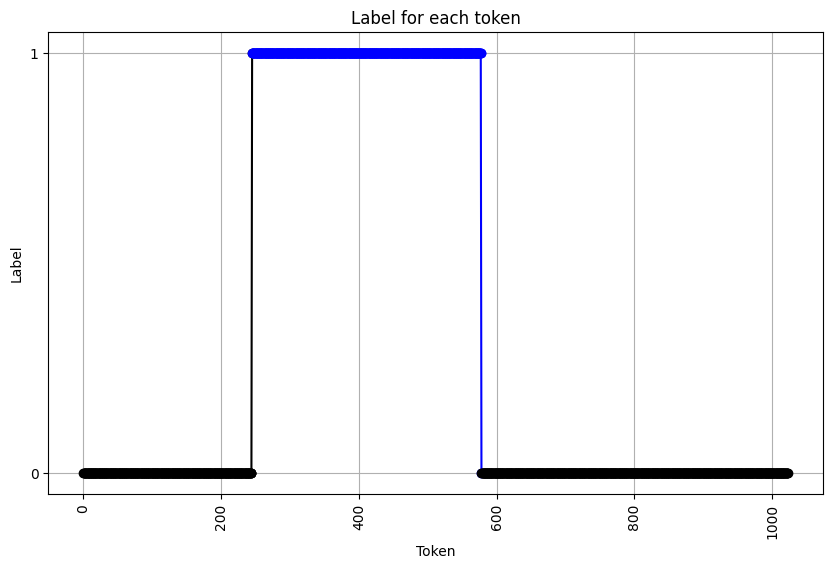

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:26<00:00,  2.87s/it]

MGYFQMARNIEEIFGGVVVAPHQIPFTYTSTNGGETFLSLPFYPITGFVTINGGVQVPLDNFEINGNTLYLGRELEPSDVVFCLFDKIMSPQDASNNAIRIYKFLSVGGETEFTPDFTAYGVQSLYIDGKYKTPGEDYNYFKTSNKVVLDNGLAAGVWVVAEMNIKQNIPALAGNDGASQIGTLSGKTVQEEINEIPTEINDAVDGIYQSLQLHQLPESGAMKIGLTTGETVEEAIASLKRRTMSIMPEDFVNLSTDTEKLLAAVAYAKANNIETVLLMPGKTYTFTGTQGLDIDLGYFSFVCPFGRSYIDFSNFTGPYCLWAHSSQSYPYGARNHCHTMKGVHAKAAIQGINQALLLLGNNNNSSNGTYNGDCKIESCLFSTADIVVMGSASTWRYKFLECGFMMETAGTYAMYFPAGISDSGESITFQNCKIFDMKRCPILLACNNFAIGMPGTSVLNTPIQITGAGAMIVLDSAANIENPGATTWYRYAEVTGVAARLILNGATLVCNGPSNQTKPLFYVGTNAFIDFSHVKTPGNAYQFYSGDEGYNTFVEGPGFVIANSCIADIASGAGNIPLHKSLNPIRNYAFASGDTTSWSFNNQGSPSQTVVVAPEYGFSGYGARMTSFGSLSCYLTQNAKVTNNNYFTTTIKLRTVQAGTSSVGAGALSINFYDRNGVSVQASSIATISNTVGSWVSIGNFIQGRVPQSAEYAEVSIRCREGAIIDVDSVIINFS




In [19]:
for fasta_file in tqdm(os.listdir(path_out)) :
    fastas = SeqIO.parse(f"{path_out}/{fasta_file}" , "fasta")
    tmp_results = []
    for record in fastas :
        if record.id in dpos :
            print(record.description)
            prediction, sequence_outputs = predict_sequence(model_classifier, str(record.seq))
            plot_token(sequence_outputs)
            print(record.seq)
            print("\n")

In [39]:
boundaries = {}
for fasta_file in tqdm(os.listdir(path_out)) :
    fastas = SeqIO.parse(f"{path_out}/{fasta_file}" , "fasta")
    tmp_results = []
    for record in fastas :
        if record.id in dpos :
            start , stop = 10000 , 0 
            print(record.description)
            prediction, sequence_outputs = predict_sequence(model_classifier, str(record.seq))
            for index, label in enumerate(sequence_outputs) : 
                if label != 0 :
                    if index < start :
                        start = index
                    elif index > stop :
                        stop = index
            boundaries[record.id] = (start, stop)


  0%|                                                                                                                                                                                | 0/30 [00:00<?, ?it/s]

CAD5241751.1 gp7 baseplate wedge subunit [Klebsiella phage vB_KpM-SoFaint]


  3%|█████▌                                                                                                                                                                  | 1/30 [00:01<00:37,  1.29s/it]

YP_009190729.1 baseplate wedge subunit [Klebsiella phage JD18]


  7%|███████████▏                                                                                                                                                            | 2/30 [00:02<00:33,  1.19s/it]

CAD5241339.1 gp36 hinge connector long tail fiber [Klebsiella phage vB_KpM-Wobble]
CAD5239183.1 hypothetical protein [Klebsiella phage vB_KaS-Ahsoka]


 10%|████████████████▊                                                                                                                                                       | 3/30 [00:03<00:27,  1.02s/it]

CAD5204309.1 side tail fiber [Klebsiella phage vB_KppS-Raw]


 13%|██████████████████████▍                                                                                                                                                 | 4/30 [00:03<00:23,  1.13it/s]

CAD5239143.1 tail fiber family protein [Klebsiella phage vB_KqP-Goliath]
CAD5239132.1 tail tubular protein B [Klebsiella phage vB_KqP-Goliath]


 17%|████████████████████████████                                                                                                                                            | 5/30 [00:05<00:25,  1.01s/it]

CAD5241751.1 gp7 baseplate wedge subunit [Klebsiella phage vB_KpM-SoFaint]


 20%|█████████████████████████████████▌                                                                                                                                      | 6/30 [00:06<00:24,  1.01s/it]

CAD5242572.1 gp7 baseplate wedge subunit [Klebsiella phage vB_KoM-Pickle]


 27%|████████████████████████████████████████████▊                                                                                                                           | 8/30 [00:07<00:17,  1.25it/s]

CAD5241751.1 gp7 baseplate wedge subunit [Klebsiella phage vB_KpM-SoFaint]


 30%|██████████████████████████████████████████████████▍                                                                                                                     | 9/30 [00:08<00:17,  1.18it/s]

YP_009626500.1 hinge connector of long tail fiber protein distal connector [Klebsiella phage PMBT1]
CAD5242086.1 gp7 baseplate wedge subunit [Klebsiella phage vB_KoM-Liquor]


 33%|███████████████████████████████████████████████████████▋                                                                                                               | 10/30 [00:09<00:19,  1.01it/s]

CAD5204309.1 side tail fiber [Klebsiella phage vB_KppS-Raw]


 37%|█████████████████████████████████████████████████████████████▏                                                                                                         | 11/30 [00:10<00:19,  1.02s/it]

CAD5239132.1 tail tubular protein B [Klebsiella phage vB_KqP-Goliath]


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                              | 13/30 [00:13<00:18,  1.08s/it]

CAD6025329.1 hinge connector of long tail fiber distalconnector [Klebsiella phage vB_KoM-MeTiny]
CAA7537902.1 baseplate wedge subunit [Klebsiella phage vB_KpnM_05F]


 47%|█████████████████████████████████████████████████████████████████████████████▉                                                                                         | 14/30 [00:16<00:25,  1.57s/it]

YP_010644708.1 tail spike protein [Klebsiella phage vB_KvM-Eowyn]
YP_010644710.1 bacteriolytic protein [Klebsiella phage vB_KvM-Eowyn]
YP_010644716.1 tail fiber protein [Klebsiella phage vB_KvM-Eowyn]
YP_010644722.1 tail fiber protein [Klebsiella phage vB_KvM-Eowyn]
YP_010644718.1 tail fiber family protein [Klebsiella phage vB_KvM-Eowyn]
YP_010644720.1 hypothetical protein [Klebsiella phage vB_KvM-Eowyn]
YP_010644713.1 tail fiber protein [Klebsiella phage vB_KvM-Eowyn]


 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                              | 16/30 [00:25<00:40,  2.91s/it]

CAD5240565.1 hypothetical protein [Klebsiella phage vB_KqM-LilBean]
CAD5240417.1 putative tail fiber protein [Klebsiella phage vB_KqM-Bilbo]
CAD5240411.1 putative tailspike protein [Klebsiella phage vB_KqM-Bilbo]
CAD5240429.1 hypothetical protein [Klebsiella phage vB_KqM-Bilbo]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 18/30 [00:32<00:37,  3.11s/it]

CAD5240036.1 hypothetical protein [Klebsiella phage vB_KppS-Samwise]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 19/30 [00:33<00:29,  2.69s/it]

CAD5242887.1 phage baseplate wedge initiator [Klebsiella phage vB_KoM-Flushed]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 20/30 [00:36<00:25,  2.56s/it]

CAD5239047.1 tail tubular protein B [Klebsiella phage vB_KpP-Screen]
CAD5239035.1 tail fiber family protein [Klebsiella phage vB_KpP-Screen]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 21/30 [00:38<00:22,  2.51s/it]

YP_009626500.1 hinge connector of long tail fiber protein distal connector [Klebsiella phage PMBT1]
CAD5242086.1 gp7 baseplate wedge subunit [Klebsiella phage vB_KoM-Liquor]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 23/30 [00:40<00:13,  1.95s/it]

CAD5240110.1 hypothetical protein [Klebsiella phage vB_KaS-Gatomon]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 24/30 [00:41<00:09,  1.63s/it]

CAD5240417.1 putative tail fiber protein [Klebsiella phage vB_KqM-Bilbo]
CAD5240411.1 putative tailspike protein [Klebsiella phage vB_KqM-Bilbo]
CAD5240429.1 hypothetical protein [Klebsiella phage vB_KqM-Bilbo]
CAD5240423.1 hypothetical protein [Klebsiella phage vB_KqM-Bilbo]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 25/30 [00:47<00:14,  2.81s/it]

CAD5235910.1 hypothetical protein [Klebsiella phage vB_KppS-Pokey]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 28/30 [00:48<00:03,  1.58s/it]

CAD5240876.1 putative tail fiber [Klebsiella phage vB_KqM-Westerburg]
CAD5240864.1 putative tailspike protein [Klebsiella phage vB_KqM-Westerburg]
CAD5240874.1 tail spike protein head-binding protein [Klebsiella phage vB_KqM-Westerburg]
CAD5240880.1 unknown product [Klebsiella phage vB_KqM-Westerburg]
CAD5240870.1 putative tail fiber protein [Klebsiella phage vB_KqM-Westerburg]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:53<00:00,  1.80s/it]


In [40]:
boundaries

{'CAD5241751.1': (164, 379),
 'YP_009190729.1': (183, 535),
 'CAD5241339.1': (60, 135),
 'CAD5239183.1': (382, 614),
 'CAD5204309.1': (294, 741),
 'CAD5239143.1': (83, 185),
 'CAD5239132.1': (303, 582),
 'CAD5242572.1': (163, 378),
 'YP_009626500.1': (39, 188),
 'CAD5242086.1': (162, 378),
 'CAD6025329.1': (41, 117),
 'CAA7537902.1': (163, 378),
 'YP_010644708.1': (109, 575),
 'YP_010644710.1': (69, 502),
 'YP_010644716.1': (74, 471),
 'YP_010644722.1': (122, 607),
 'YP_010644718.1': (72, 408),
 'YP_010644720.1': (168, 455),
 'YP_010644713.1': (70, 365),
 'CAD5240565.1': (75, 447),
 'CAD5240417.1': (408, 597),
 'CAD5240411.1': (502, 839),
 'CAD5240429.1': (131, 491),
 'CAD5240036.1': (121, 382),
 'CAD5242887.1': (207, 416),
 'CAD5239047.1': (303, 582),
 'CAD5239035.1': (83, 185),
 'CAD5240110.1': (52, 298),
 'CAD5240423.1': (87, 315),
 'CAD5235910.1': (292, 741),
 'CAD5240876.1': (71, 550),
 'CAD5240864.1': (502, 839),
 'CAD5240874.1': (96, 178),
 'CAD5240880.1': (110, 424),
 'CAD52408

In [41]:
def find_longest_non_zero_sequence(arr, gap_tolerance):
    start = -1
    end = -1
    current_start = -1
    current_length = 0
    max_length = 0

    for i, value in enumerate(arr):
        if value != 0:
            if current_start == -1:
                current_start = i
            current_length += 1

            if current_length > max_length:
                max_length = current_length
                start = current_start
                end = i

        elif current_start != -1 and current_length > 0:
            if current_length > max_length and current_length >= gap_tolerance:
                max_length = current_length
                start = current_start
                end = i - 1  # Adjust the end index to the last non-zero element
            current_start = -1
            current_length = 0

    if current_length > max_length and current_length >= gap_tolerance:
        start = current_start
        end = len(arr) - 1

    return start, end


gap_tolerance = 10  # Set your desired gap tolerance here
boundaries_2 = {}
for fasta_file in tqdm(os.listdir(path_out)):
    fastas = SeqIO.parse(f"{path_out}/{fasta_file}", "fasta")
    tmp_results = []
    for record in fastas:
        if record.id in dpos:
            sequence_outputs = predict_sequence(model_classifier, str(record.seq))
            start, end = find_longest_non_zero_sequence(sequence_outputs, gap_tolerance)
            boundaries_2[record.id] = (start, end)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:02<00:00,  2.08s/it]


In [42]:
boundaries_2

{'CAD5241751.1': (0, 1),
 'YP_009190729.1': (0, 1),
 'CAD5241339.1': (0, 1),
 'CAD5239183.1': (0, 1),
 'CAD5204309.1': (0, 1),
 'CAD5239143.1': (0, 1),
 'CAD5239132.1': (0, 1),
 'CAD5242572.1': (0, 1),
 'YP_009626500.1': (0, 1),
 'CAD5242086.1': (0, 1),
 'CAD6025329.1': (0, 1),
 'CAA7537902.1': (0, 1),
 'YP_010644708.1': (0, 1),
 'YP_010644710.1': (0, 1),
 'YP_010644716.1': (0, 1),
 'YP_010644722.1': (0, 1),
 'YP_010644718.1': (0, 1),
 'YP_010644720.1': (0, 1),
 'YP_010644713.1': (0, 1),
 'CAD5240565.1': (0, 1),
 'CAD5240417.1': (0, 1),
 'CAD5240411.1': (0, 1),
 'CAD5240429.1': (0, 1),
 'CAD5240036.1': (0, 1),
 'CAD5242887.1': (0, 1),
 'CAD5239047.1': (0, 1),
 'CAD5239035.1': (0, 1),
 'CAD5240110.1': (0, 1),
 'CAD5240423.1': (0, 1),
 'CAD5235910.1': (0, 1),
 'CAD5240876.1': (0, 1),
 'CAD5240864.1': (0, 1),
 'CAD5240874.1': (0, 1),
 'CAD5240880.1': (0, 1),
 'CAD5240870.1': (0, 1)}

In [34]:
boundaries

{}

In [45]:
with open("/media/concha-eloko/Linux/PPT_clean/in_vitro/Townsed/Dpos_boundaries.Towndsend.tsv","w") as outfile :
    outfile.write(f"protein_id\tannotation\tphage\tboundaries\tfull sequence\tdpo_sequence\n")
    for fasta_file in tqdm(os.listdir(path_out)) :
        fastas = SeqIO.parse(f"{path_out}/{fasta_file}" , "fasta")
        tmp_results = []
        for record in fastas :
            if record.id in dpos and boundaries[record.id][1]-boundaries[record.id][0] >= 190 :
                start , end = boundaries[record.id][0] , boundaries[record.id][1]
                phage_name = record.description.split("[")[1].split("]")[0].split(" ")[-1]
                outfile.write(f"{record.id}\t{' '.join(record.description.split(' ')[1:-4])}\t{phage_name}\t{start}-{end}\t{str(record.seq)}\t{str(record.seq)[start:end]}\n")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 1102.65it/s]


***
# Other predictions : 

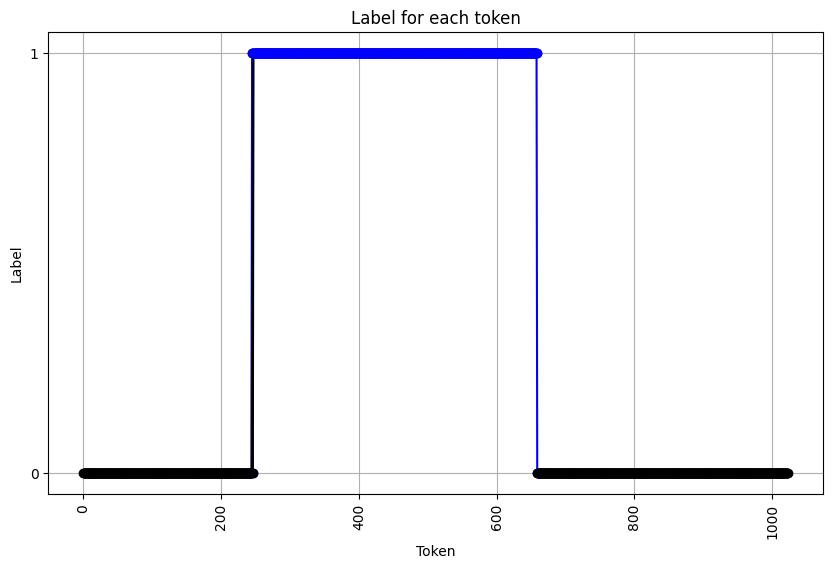

((1.0, 0.9999994039535522), 'lcl|OP125547.1_prot_UVD31996.1_1 [locus_tag=vBKpnPKlyazma_orf001] [protein=tail fiber protein] [protein_id=UVD31996.1] [location=965..3337] [gbkey=CDS]')
MAIVLNDITSGYNLSTINSNFQKIEDYINDKLLTRADTGVAGEAMMKRALDMNGNKILNVFVDVNDANSLLTVGAADSRYYNVSGDTLTGPMDANSQIINNLPSPTLPSQPATKAYADAIQQDVNYNESRSLRFPDNVDEMSGVVGRANSLQGYNDVGKPVSIFAMTSTADLALKLASSGSGLGAGLVGYDIASTYSNNTVGNKLNLMLTPWDFGAVADGTLHPLSEYYATLAAAQAVYPFVTSLTQSIDYAAIQKCVNTMITRGAAGMSMGGRGRFCINDTILLNKTGSVNDANKTVDFSGALIETYGGNIILNDTSFTSWTLTGGVTVSSGTLVFNGTTSTQANAAITLTGLTVGKRYAVSVVTESYTSEGYLRIRMGTTAISRPNEYGPGVRHAEFTATATSQVLNLVDDTYTITPTQCVVKEVDVREATYAFNVYQTGTSITHGSVVFNNFRVYNRSSSCFAGLRTENLNHAVFDGITSFVGFYGMGWHPNNTSTWSENITVNVLLGANCREVVRFSRPVAGTGLNSFARTNIKRIVFSGCRYAMATEAGTAVYDSVIGSINGNLTSNFRAVLLLHGDQTDSVVESIRVENNSAPSTAGVFEYGRNDLRRINVRNVGAYTDVNLLATGSLSAGTVSLENAITGTDFRPASPYFGLTTHLPQSGKLGTGLTYIAGTYTWSEILLNCTPSTGYVVGTPYNLAPAHGIVDLDLALRNADGTSYQGTKTAIKMLKGTVETANVNKVVVYNSTHTISGEAITVTWPGSTAPTVSHNAASNRSIQVYARWTV


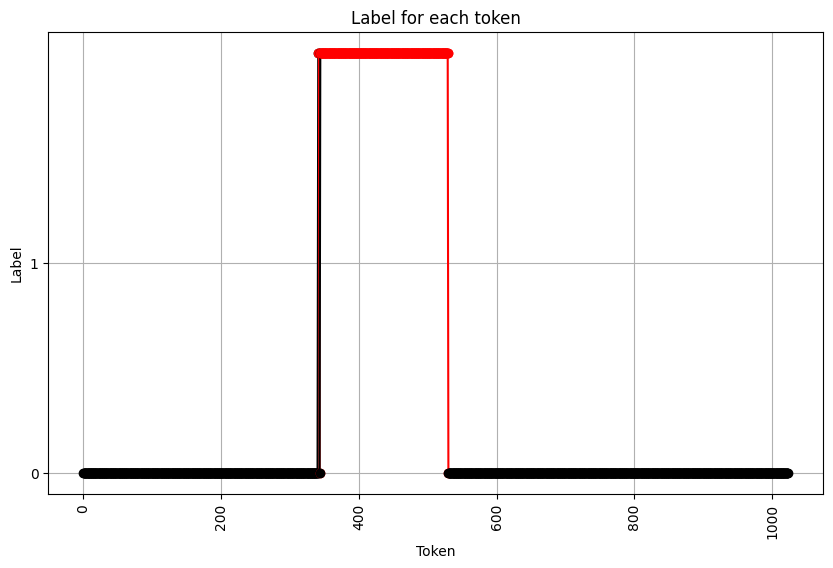

((1.0, 0.9999998807907104), 'lcl|OP125547.1_prot_UVD32007.1_12 [locus_tag=vBKpnPKlyazma_orf012] [protein=tubular tail B-like protein] [protein_id=UVD32007.1] [location=10945..13251] [gbkey=CDS]')
MARQTAAIEVNTFVRGIITEASPLTFPENASIDEQNMVLNKDGSRERRLGMDYESGFTTFSANVSAAENPVFNSFVWKQPGGFTESEFSVVQSGRRLTFIDNTATVLSAAVKATYDIGNNVTSKISLAAVDGILVAATGSGDIYAFDYDGANISQTTSRLKIRDMFGVEDIINGQDLRTGQGVQVRPSVQTDAHIYNLRNQTFAYPRYRGDGDDAETSTCPIFSFHEEEGTFQANSDNLITYLYANANDSDDRNTRRYFQKDNLNNPLGTNLAPMGFFIIDAMNRGASRLEAVYDLYNTYPDLQYPITSLPTDATPGGASVVATYAGRAWFAGFSSQVVDGDKESPRMTSYVLFSRLVDKISDIYKCYQDGDPTSSETPDLVDTDGGFLRLDGAYNISAMVNVGDALMVVAENGVWKITGGSGYGFSATNYMTTKLAEYGCISPGSVVLVDSTFMYWSEDGIYHVTKNQYGDWAANNISNTTIQDLYDDIAYGNKVACQSTYDRYTRCVRWMFNNLASSSGSTRELILDVNLSAFYISDVAPVSGTFPRMVAYVKTPPFKVTTESTQVITGAQDTVVDSSANTVVVQDSSVLSGVSETYFVTIDSEQSGDLKLTFSYYRDGTFTDWVSKNGTGVDAAAYLLTGWTGGGDYQRQKQAPLLTVYCIKTETGFDSEYEPVNASSVLVQGQWSWTNLAASNKWTSTFQAYRHTRLWAPEDNSSPFNDGNHVVVTRNRLRGRGRVLSLLFKTEPKKAFKLLGWSHVMMVNGSV


In [8]:
path_out = "/home/concha-eloko/Téléchargements"
from Bio import SeqIO
from tqdm import tqdm 

fastas = SeqIO.parse(f"{path_out}/OP125547.fasta" , "fasta")
tmp_results = []
for record in fastas :
    if len(record.seq) >= 180 :
        prediction, sequence_outputs = predict_sequence(model_classifier, str(record.seq))
        if prediction[0] == 1 :
            a = (prediction , record.description)
            tmp_results.append(a)
            plot_token(sequence_outputs)
            print(a)
            print(str(record.seq))
        else :
            pass


In [15]:
OR538763
OR538761

[]

In [6]:
tmp_results

[]

In [ ]:
# Papers with depo :

OQ412633
ON165415


OR538763

AY543070
NC_029083
MN166083
OP114732


OK631813
OK631812
MZ890186
OK631811

***
### Individual sequence : 

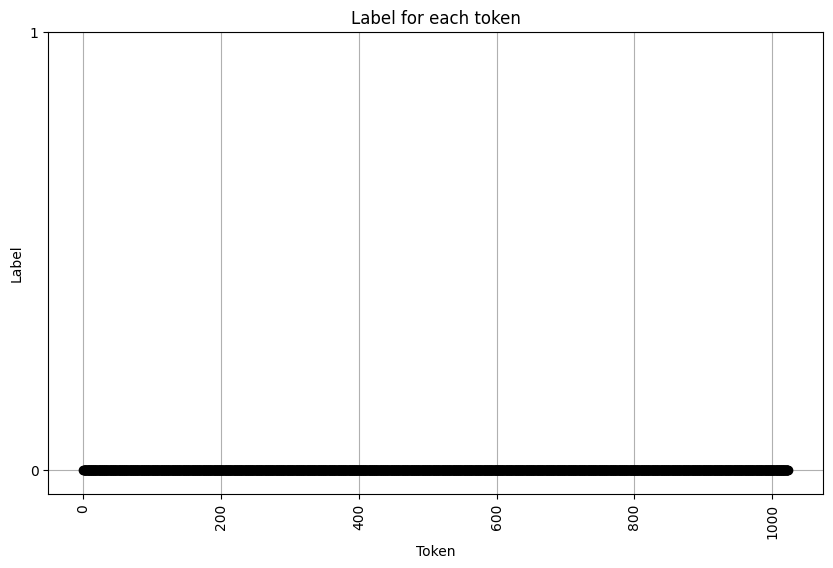

In [6]:
path_out = "/home/concha-eloko/Téléchargements"
from Bio import SeqIO
from tqdm import tqdm 


#seq = "MGSVKTKRKLLDYLEFNSKDNIFTISTKKKIAESVGVSVSTINNNLKKLEEENKIAVATKKGHNGGIVITLIKERFNTEDLVEFNKSNDNIIQSAQKYAEDLRDKHFPTYTYQRKENRRRTKQEMAKYKAIKDKNRRIILDMNLELSNMNYPSKEVFNMSYDPEGFYKAYILCKLYDMYCIAHMNARRDFHERRIEKDDLEPYQVEHHKKYIEFYKNQLVVFLSKNSVSDNFFGSKTFNTFYNFYNKIKDLNNFNVFLYMQNVFNNVSYVYENTNSSINIPMPNYFNSDKYFEQYYKYIDTIKKNVNNTQRHLGDTELLVDSTIYKSNPALNQLQQMYMSKLNDEIHDIDTMFEKALDLEDLEFGFVRDNKHLTLLNFSDKVDRAIKDMEKEEAKVINKFVKQLIINEYAPTSFSSNVRTSLFPMQRHHIISELELNNIPLKDNLINIGLVSDNADLRNLTKQDISNLTSVAYDYLVLSKNSSTYYVLRMFADFMGYEVNIKDVKHILTKYNLEDLIPLTSYGMLDYNRLKRESEKI"
#seq = "LSSFLKNLHPLLRRKKDKNLNEDTNYILLNTLNEELNTVERDTIESKLQSSLKSATGTYLDKFGDWFGVYRKVDEEDDKYRQRIIKYLLLKRGTNNAIIEGIKYYLDRDDLNISIYEPFKNIFYTNKSELNGNDKLMGYYYRFAVINVTIGNYFPLEIIDIINEFKPAGVKLYVTYDGGATNNGSLIYQWLNGSMKVEMYEDITNFYGYDELLYGHINLGLRKTDSLNYKSVFINNKSLINSEDVLTGSSNVGRIFNNVSIKSSYNYTPQYNSSVANIISELKNKSEELSTDFYLHTNEKNNVSIPVTFNSNTGIEYIYNNFNIREYLLKTKPVLLNKTKRETSDYIGQVDFKLTLKAVLPPNDYVNIVLQIYDFDRNRWNTINYDSVSFYEKDYDFSIGYLNDYLNDDLNMFTRLQVYGYDDEVTLDINYLDMVFYHYEPGVYTIHPYTPVVKLYDEIQSMFYVKAYKVFSPTNGDIISQPSYKKVQYIKVTDNKSIDLNPQEIYGNSKYLTDTETVNSYINNLEHSIIISSYSSIEEKYRQGYNVDTDKHNLIEKIYKFNGVRTDIQDFKIEVTHAPNPDLYIMISEDGKNWETVTKIDYSKDNEVETTISNKVVDLYGLKFVNYSDITPMSEVLLSSINTIPIRDLIGEKNVSTMPIGYFNALWTNMDTEYSVILDTLKVISDTNNGIIDSSSGEIIKSTVLDINTYTSLDDIDYSKLKYVEDLRLGSARTLDELSELQFTDSSYYVDTNPKVNFFETEISLAPRETVNILKDSNIPQIVSYTNGAKYELEQPIISGHKYKVTILGELSPEVTTVNVVNTNTGMSEVVFYPAEIDKSQGLLEKEFTAKTTSIRKNESVKIYTDSNINEALKINKISLVEIK"


prediction, sequence_outputs = predict_sequence(model_classifier, seq)
if prediction[0] == 1 :
    a = (prediction , record.description)
    tmp_results.append(a)
    plot_token(sequence_outputs)
    print(a)
    print(record.seq)
else :
    plot_token(sequence_outputs)